In [25]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset, random_split

import pywt
from scipy.signal import welch
from scipy.stats import chi2_contingency, ttest_ind

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (
    r2_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    silhouette_score,
)

from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import shap
from imblearn.over_sampling import SMOTE
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

from matplotlib.lines import Line2D
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D

In [2]:
class EEGUtil:
    @staticmethod
    def load_data(file_path, column_names=['spike hz']):
        """Load multi-channel EEG data from a CSV file and normalize it.

        Parameters:
        - file_path: Path to the CSV file.
        - column_names: List of EEG signal column names to load.

        Returns:
        - signal: 2D numpy array (channels × time), normalized.
        """
        data = pd.read_csv(file_path)

        # 确保所有列都存在
        available_columns = [col for col in column_names if col in data.columns]
        if not available_columns:
            raise ValueError(f"None of the specified columns {column_names} exist in {file_path}")

        signal = data[available_columns].values.T  # (channels, time)

        # **🔥 强制 z-score 归一化**
        mean = np.mean(signal, axis=1, keepdims=True)
        std = np.std(signal, axis=1, keepdims=True)

        # 防止标准差为 0，避免 NaN
        std[std == 0] = 1e-8  
        
        #signal = (signal - mean) / std  # 归一化
        
        return signal

    @staticmethod
    def padding(signal, target_length, mode="constant", constant_value=0):
        """Pad or truncate multi-channel signal to the target length."""
        signal = np.array(signal)  # Ensure it's a NumPy array
        channels, current_length = signal.shape
        
        if current_length >= target_length:
            return signal[:, :target_length]  # Truncate

        padding_size = target_length - current_length
        if mode == "constant":
            pad_values = np.full((channels, padding_size), constant_value)
        elif mode == "reflect":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='reflect')[:, -padding_size:]
        elif mode == "cyclic":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='wrap')[:, -padding_size:]
        elif mode == "edge":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='edge')[:, -padding_size:]
        elif mode == "random":
            pad_values = np.random.uniform(low=np.min(signal), high=np.max(signal), size=(channels, padding_size))
        else:
            raise ValueError(f"Unsupported padding mode: {mode}")

        return np.hstack((signal, pad_values))  # Concatenate along time axis
    

class EEGDataset(Dataset):
    def __init__(self, data_folder, outcome_file=None, ssd_file=None,start_time=16,target_length=600, strategy='padding', 
                 padding_mode="constant", use_labels=False, augment=False,num_good=1,num_bad=1,column_names=['spike hz']):
        
        """
        EEG signal datasets with support for data enhancement (random fill). 

        Parameters: 
        - data_folder: path of the EEG data folder 
        - outcome_file: CSV file with patient ID and outcome (optional) 
        - target_length: indicates the padding length of the target 
        - strategy: wavelet ('padding', 'wavelet', 'psd') 
        - padding_mode: indicates the fill mode ('constant', 'reflect',...). 
        - use_labels: indicates whether to use labels 
        - augment: Whether data enhancement is enabled (randomly fill different lengths) 
        """

        self.use_labels = use_labels
        self.data_folder = data_folder
        self.target_length = target_length
        self.strategy = strategy
        self.padding_mode = padding_mode
        self.augment = augment # 是否启用数据增强
        self.column_names = column_names #Feature Chosen
        
        self.num_good = num_good
        self.num_bad = num_bad
        
        self.start_time=start_time
        self.end_time=int((target_length/12)+self.start_time)

        self.file_list = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
       
        # Read 'rosc sec' start time
        ssd_df = pd.read_csv(ssd_file)
        # Get `pat_ID`
        ssd_df["pat_ID"] = ssd_df["fn"].str.extract(r"(ICARE_\d+)")
        #  Take the smallest 'rosc sec' of each 'pat ID' 
        self.rosc_dict = ssd_df.groupby("pat_ID")["rosc_sec"].min().to_dict()
        
        # LOAD Labels
        self.outcome_dict = {}
        if use_labels and outcome_file:
            self.outcome_data = pd.read_csv(outcome_file)
            self.outcome_dict = self.outcome_data.set_index('pat_ID')['outcome'].to_dict()
            self.file_list = [f for f in self.file_list if f.split('.')[0] in self.outcome_dict]
        
        self.valid_files = []
        # Filter EEG data conforming to 16h-68h rules
        for f in self.file_list:
            pat_id = f.split('.')[0]

            if pat_id in self.rosc_dict:
                file_path = os.path.join(self.data_folder, f)
                signal = EEGUtil.load_data(file_path, column_names=self.column_names)  #Load Multiple Channel
                rosc_sec = float(self.rosc_dict[pat_id])  # Ensure `rosc_sec` is a float

                # **EEG recording time range**
                start_time = rosc_sec
                end_time = start_time + signal.shape[1] * 300  # Each point represents 5 minutes (=300 seconds)
                # **Skip if the data is completely outside the 16h-68h observation window**
                if end_time < self.start_time * 3600 or start_time > self.end_time * 3600:
                    #print(f"❌ Skipping {pat_id}: EEG data is out of 16h-68h range ({start_time/3600:.1f}h - {end_time/3600:.1f}h)")
                    continue  

                # **Align to the 16h-68h window**
                aligned_signal = self.align_signal(signal, rosc_sec)
                self.valid_files.append((f, aligned_signal))

        print(f"✅ Loaded {len(self.valid_files)} valid EEG files (filtered from {len(self.file_list)} total)")

        # **Count Good/Bad Outcome samples**
        self.good_outcome_count = sum(1 for f, _ in self.valid_files if self.get_label(f.split('.')[0]) == 1)
        self.bad_outcome_count = len(self.valid_files) - self.good_outcome_count

        print(f"Good Outcome: {self.good_outcome_count}, Bad Outcome: {self.bad_outcome_count}")

        # **Data Augmentation: Expanding indices**
        self.expanded_indices = []
        for idx, (filename, signal) in enumerate(self.valid_files):
            patient_id = filename.split('.')[0]
            label = self.get_label(patient_id) if self.use_labels else -1

            if self.augment:
                if self.use_labels:
                    # Good Outcome ×10, Bad Outcome ×2
                    if label == 1:
                        repeat_times = self.num_good
                    else:
                        repeat_times = self.num_bad
                else:
                    repeat_times = 1  # Data augmentation for unlabeled data
            else:
                repeat_times = 1  

            for _ in range(repeat_times):
                self.expanded_indices.append((idx, label))  # ✅ Store index & label
    
    def __len__(self):
        # print(f"📏 Dataset __len__: {len(self.expanded_indices)}")  # Ensure `expanded_indices` length is correct
        return len(self.expanded_indices)  # ✅ Must return the number of samples after data augmentation
    
    def __getitem__(self, idx):
        original_idx, label = self.expanded_indices[idx]
        filename, signal = self.valid_files[original_idx]  # Directly retrieve the **aligned** signal
        patient_id = filename.split('.')[0]

        # Get label
        label = -1
        if self.use_labels:
            label = self.get_label(patient_id)

        # Perform data augmentation (varies each time)
        if self.augment:
            augmented_signal = self.augment_signal(signal)  # ✅ Apply augmentation directly to the **aligned signal**
        else:
            augmented_signal = signal  # ✅ Use the aligned signal directly

        return torch.tensor(augmented_signal, dtype=torch.float32), label
    
    def align_signal(self, signal, rosc_sec):
        """ Align EEG data to the 16h-68h observation period """

        target_length = self.target_length  # Number of `5min` windows for 52 hours (624)
        total_signal_length = signal.shape[1]  # Total length of the EEG recording
        
        rosc_sec = float(rosc_sec)  # ✅ Ensure `rosc_sec` is a float
        # print(f"🔍 Processing patient data: rosc_sec={rosc_sec}, total_signal_length={total_signal_length}")

        # **Calculate the starting position of '16h' in the EEG recording**
        start_sec = (self.start_time * 3600) - rosc_sec  
        if start_sec < 0:
            pad_size = abs(start_sec) / 300  # Calculate the number of windows to pad
            start_index = 0  # Start extracting data from the beginning of the EEG recording
        else:
            pad_size = 0  # No padding needed
            start_index = int(start_sec // 300)  # ✅ Convert to integer

        # **Calculate the endpoint index for '68h'**
        end_index = int(min(start_index + target_length, total_signal_length))  # ✅ Convert to integer

        # **Extract EEG data for the 16h-68h observation period**
        aligned_signal = signal[:, start_index:end_index]

        # **Pre-padding (if `rosc_sec > 16h`)**
        if pad_size > 0:
            aligned_signal = EEGDataset.pad_signal(aligned_signal, target_length, self.padding_mode, padding_position="pre")

        # **Post-padding (if data is less than 52 hours)**
        aligned_signal = EEGDataset.pad_signal(aligned_signal, target_length, self.padding_mode, padding_position="post")

        # print(f"✅ Aligned signal length: {len(aligned_signal)}")
        return aligned_signal
    
    def pad_signal(signal, target_length, mode="constant", constant_value=np.nan, padding_position="post"):
        """ Pad EEG signal to ensure it reaches `target_length`.

        Parameters:
        - signal: Original EEG signal (numpy array)
        - target_length: Target length (52h = 624 `5min` windows)
        - mode: Padding mode:
            - `constant`: Fill with a fixed value (`constant_value`)
            - `reflect`: Mirror padding
            - `cyclic`: Cyclic padding
            - `edge`: Edge padding
            - `random`: Fill with random values between [min, max]
        - padding_position: `"pre"` (pad at the beginning) or `"post"` (pad at the end)

        Returns:
        - Padded EEG signal (numpy array)
        """

        channels, current_length = signal.shape
        
        if current_length >= target_length:
            return signal[:, :target_length]  # Truncate if already long enough

        padding_size = target_length - current_length  # Number of elements to pad

        if mode == "constant":
            pad_values = np.full((channels, padding_size), constant_value)  # Make sure padding shape matches
        elif mode == "reflect":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='reflect')[:, -padding_size:]
        elif mode == "cyclic":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='wrap')[:, -padding_size:]
        elif mode == "edge":
            pad_values = np.pad(signal, ((0, 0), (0, padding_size)), mode='edge')[:, -padding_size:]
        elif mode == "random":
            pad_values = np.random.uniform(low=np.min(signal), high=np.max(signal), size=(channels, padding_size))
        else:
            raise ValueError(f"Unsupported padding mode: {mode}")

        # Ensure proper concatenation along the time axis
        if padding_position == "pre":
            padded_signal = np.hstack((pad_values, signal))  # Pad at the beginning
        else:
            padded_signal = np.hstack((signal, pad_values))  # Pad at the end

        return padded_signal[:, :target_length]  # Ensure exact target length
    
    def augment_signal(self, signal):
        """ Data augmentation: Shift EEG data within the 16h-68h observation period """

        target_length = self.target_length  # Number of `5min` windows for 52 hours (624)
        channels, current_length = signal.shape  # Current EEG recording length

        # **Check if already aligned to 16h-68h before augmentation**
        if current_length != target_length:
            raise ValueError(f"Before augmentation, signal length should be {target_length}, but received {current_length}")

        # **Augmentation Strategy 1: Random time shift within ±60min**
        max_shift = 12  # `5min` windows, 60 minutes = 12 data points
        shift = np.random.randint(-max_shift, max_shift + 1)  # Random shift in [-12, 12]

        # **Compute new starting index and ensure it remains within bounds**
        start_index = max(0, min(current_length - target_length, shift))
        end_index = min(start_index + target_length, current_length)

        # **Extract EEG data after shifting**
        augmented_signal = signal[:, start_index:end_index]

        # **Augmentation Strategy 2: Apply padding based on `shift` direction**
        if augmented_signal.shape[1] < target_length:
            padding_size = target_length - augmented_signal.shape[1]

            if shift > 0:
                # **向右平移: 在前面填充**
                pad_values = self.pad_signal(np.zeros((channels, padding_size)), target_length, self.padding_mode)
                augmented_signal = np.hstack((pad_values, augmented_signal))  # **确保形状正确**
            elif shift < 0:
                # **向左平移: 在后面填充**
                pad_values = self.pad_signal(np.zeros((channels, padding_size)), target_length, self.padding_mode)
                augmented_signal = np.hstack((augmented_signal, pad_values))
            else:
                # **不平移，直接填充**
                augmented_signal = self.pad_signal(augmented_signal, target_length, self.padding_mode)

        return augmented_signal

    def get_label(self, patient_id):
        """ Get sample label (1 = Good Outcome, 0 = Bad Outcome) """
        return 1 if self.outcome_dict.get(patient_id, 'Bad Outcome') == 'Good Outcome' else 0

    def compare_data_augmentation(self):
        """ Compare the number of samples before and after data augmentation. """
        original_count = len(self.valid_files)  # Count only files that meet the 16h condition
        augmented_count = len(self.expanded_indices)  # Count the number of augmented samples

        print(f"Data count before augmentation: {original_count}")
        print(f"Data count after augmentation: {augmented_count}")
        print(f"Augmentation ratio: {augmented_count / original_count:.2f}x")

        if self.use_labels:
            # Count Good Outcome and Bad Outcome samples in original data (filtered_files)
            good_outcome_original = sum(1 for f, _ in self.valid_files if self.get_label(f.split('.')[0]) == 1)
            bad_outcome_original = original_count - good_outcome_original  # Remaining are Bad Outcome samples

            # Count Good Outcome and Bad Outcome samples after augmentation
            good_outcome_augmented = sum(
                1 for (idx, _) in self.expanded_indices  # ✅ Use only idx, ignore label
                if self.get_label(self.valid_files[idx][0].split('.')[0]) == 1
            )
            bad_outcome_augmented = augmented_count - good_outcome_augmented  # Remaining are Bad Outcome samples

            print(f"Good Outcome before augmentation: {good_outcome_original}, after augmentation: {good_outcome_augmented}")
            print(f"Bad Outcome before augmentation: {bad_outcome_original}, after augmentation: {bad_outcome_augmented}")

        return original_count, augmented_count
    
    
# AugmentedEEGDataset (适配多通道)
class AugmentedEEGDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, eeg_dataset_instance, augment=True, num_good=10, num_bad=2):
        self.base_dataset = base_dataset
        self.eeg_dataset_instance = eeg_dataset_instance  # 保存实例
        self.augment = augment
        self.num_good = num_good
        self.num_bad = num_bad
        self.expanded_data = []

        for i in range(len(base_dataset)):
            signal, label = base_dataset[i]
            repeat = num_good if label == 1 else num_bad  # 按类别决定增强比例

            for _ in range(repeat):
                # **🔥 兼容多通道数据**
                signal_np = signal.numpy()
                if signal_np.ndim == 2:
                    augmented_signal = self.eeg_dataset_instance.augment_signal(signal_np)
                else:
                    augmented_signal = self.eeg_dataset_instance.augment_signal(signal_np[np.newaxis, :])  # **单通道兼容**

                self.expanded_data.append((augmented_signal, label))

    def __len__(self):
        return len(self.expanded_data)

    def __getitem__(self, idx):
        signal, label = self.expanded_data[idx]
        return torch.tensor(signal, dtype=torch.float32), label
# 统计类别信息
def count_labels(dataset):
    labels = [dataset[i][1] for i in range(len(dataset))]  # 取出所有样本的 label
    unique, counts = np.unique(labels, return_counts=True)
    return dict(zip(unique, counts))

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import pandas as pd
from torch.utils.data import DataLoader, Subset

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameter settings
latent_dim = 10  # Dimension of the latent space
initial_channels = 128  # Initial number of channels for CNN
start_time=16
seq_length = (68 - start_time) * 12  # Number of `5min` windows for 52 hours (624)
batch_size = 32
epochs = 100
alpha = 1e-12  # Adjust KL divergence weight
patience = 10  # Define the number of epochs without improvement before stopping training
padding_method = 'constant'  # Use constant padding
is_augment = True  # Enable data augmentation
num_good_train=1
num_bad_train=1
num_good_test=1
num_bad_test=1
#column_names=['BCI', 'BSAR', 'SIQ', 'SIQ_alpha', 'SIQ_beta', 'SIQ_delta', 'SIQ_theta', 'SignalSD','Prob Seizure','spike hz']
column_names=['ssd','BCI','avgspectent', 'lv_l5']
#column_names=['BCI','spike hz','meanskewamp']
#column_names=['Prob Seizure']
#column_names=['meanskewamp']
#column_names=['meanlogentropy']
#column_names=['avgspectent']


num_eeg_channels=len(column_names)

is_VAEtrain_aug=False

# Define dataset folder paths
data_folder = '5min_smoothed_data/'  # Replace with the actual data folder path
valid_outcome_data = 'valid_patients_outcome.csv'
ssd_file = 'files_art_ssd_fts_predictions.csv'

# Create EEG dataset (labels are not used when training VAE)
eeg_dataset = EEGDataset(
    data_folder='5min_smoothed_data/',
    outcome_file='valid_patients_outcome.csv',
    ssd_file=ssd_file,
    start_time=start_time,
    target_length=seq_length,
    strategy='padding',
    padding_mode=padding_method,
    use_labels=True,  # Use labels to determine class-based augmentation
    augment=False,  # Enable data augmentation
    num_good=1,
    num_bad=1,
    column_names=column_names
)


seed_value = 3  
torch.manual_seed(seed_value)

# **步骤 1：检查数据集中的 NaN 值**
def filter_nan_data(dataset):
    """筛选出不包含 NaN 的数据索引"""
    clean_indices = []
    nan_indices = []
    
    for i in range(len(dataset)):
        data, label = dataset[i]  # 获取数据和标签
        if torch.isnan(data).any():  # 检测是否包含 NaN
            nan_indices.append(i)
        else:
            clean_indices.append(i)
    
    return clean_indices, nan_indices

# 获取数据集中没有 NaN 的样本索引
clean_indices, nan_indices = filter_nan_data(eeg_dataset)

# **步骤 2：随机选择一个不含 NaN 的样本**
if clean_indices:  # 确保有可用数据
    selected_index = random.choice(clean_indices)  # 随机选取一个索引
    clean_dataset = Subset(eeg_dataset, [selected_index])  # 取出该样本
    clean_indices.remove(selected_index)  # 从列表中移除该样本索引
else:
    clean_dataset = None
    print("⚠️ 没有找到不含 NaN 的样本！")

# **步骤 3：从原始数据集中去除这个样本**
eeg_dataset_1 = Subset(eeg_dataset, nan_indices + clean_indices)  # 只保留剩余数据


train_size = int(0.8 * len(eeg_dataset_1))
test_size = len(eeg_dataset_1) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(eeg_dataset_1, [train_size, test_size])

print(f"Train set size (before augmentation): {len(train_dataset)}")
print(f"Train set label distribution: {count_labels(train_dataset)}")  
print(f"Test set size: {len(test_dataset)}")
print(f"Test set label distribution: {count_labels(test_dataset)}")  

# Augment the training set and the training set respectively
augmented_train_dataset = AugmentedEEGDataset(train_dataset, eeg_dataset, augment=is_augment, num_good=num_good_train, num_bad=num_bad_train)
augmented_test_dataset = AugmentedEEGDataset(test_dataset, eeg_dataset, augment=is_augment, num_good=num_good_test, num_bad=num_bad_test)

# Create DataLoader
if is_VAEtrain_aug:
    print("\n Augment the training set and the training set respectively:\n")
    aug_labels = [augmented_train_dataset[i][1] for i in range(len(augmented_train_dataset))]
    unique, counts = np.unique(aug_labels, return_counts=True)
    print(f"Train set size (after augmentation): {len(augmented_train_dataset)}")
    print(f"Train set label distribution (after augmentation): {dict(zip(unique, counts))}")



    aug_labels = [augmented_test_dataset[i][1] for i in range(len(augmented_test_dataset))]
    unique, counts = np.unique(aug_labels, return_counts=True)
    print(f"Test set size (after augmentation): {len(augmented_test_dataset)}")
    print(f"Test set label distribution (after augmentation): {dict(zip(unique, counts))}")

    train_loader = DataLoader(augmented_train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(augmented_test_dataset, batch_size=batch_size, shuffle=False)
else:
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


✅ Loaded 244 valid EEG files (filtered from 244 total)
Good Outcome: 44, Bad Outcome: 200
Train set size (before augmentation): 194
Train set label distribution: {0: 159, 1: 35}
Test set size: 49
Test set label distribution: {0: 40, 1: 9}


In [4]:
# Define NaNMaskedVAE model
class NaNMaskedVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, seq_length):
        super(NaNMaskedVAE, self).__init__()
        
        # Store parameters
        self.seq_length = seq_length
        self.input_dim = input_dim
        
        # Create separate VAEs for each channel (feature)
        self.vaes = nn.ModuleList([SingleChannelVAE(hidden_dim, latent_dim, seq_length) for _ in range(input_dim)])
    
    def forward(self, x):
        recon_x_list, mu_list, logvar_list = [], [], []
        
        for i in range(self.input_dim):
            recon_x, mu, logvar = self.vaes[i](x[:, i, :])  # Process each channel independently
            recon_x_list.append(recon_x.unsqueeze(1))  # Add channel dimension back
            mu_list.append(mu.unsqueeze(1))
            logvar_list.append(logvar.unsqueeze(1))
        
        recon_x = torch.cat(recon_x_list, dim=1)  # Concatenate along channel dimension
        mu = torch.cat(mu_list, dim=1)
        logvar = torch.cat(logvar_list, dim=1)
        
        return recon_x, mu, logvar
    
    def get_embedding(self, x):
        mu_list = []
        for i in range(self.input_dim):
            mu = self.vaes[i].get_embedding(x[:, i, :])
            mu_list.append(mu.unsqueeze(1))
        return torch.cat(mu_list, dim=1)

# Define a single-channel VAE for individual features
# CNN-based SingleChannelVAE
# CNN-based SingleChannelVAE with NaN Masking
class SingleChannelVAE(nn.Module):
    def __init__(self, hidden_dim, latent_dim, seq_length):
        super(SingleChannelVAE, self).__init__()
        self.seq_length = seq_length
        self.hidden_dim = hidden_dim

        # Encoder: 1D CNN layers
        self.encoder = nn.Sequential(
            nn.Conv1d(1, hidden_dim // 2, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            nn.Conv1d(hidden_dim // 2, hidden_dim, kernel_size=5, stride=2, padding=2),
            nn.ReLU()
        )
        self.flatten = nn.Flatten()
        self.mu_layer = nn.Linear(hidden_dim * (seq_length // 4), latent_dim)
        self.logvar_layer = nn.Linear(hidden_dim * (seq_length // 4), latent_dim)

        # Decoder: Transposed CNN
        self.decoder_fc = nn.Linear(latent_dim, hidden_dim * (seq_length // 4))
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(hidden_dim, hidden_dim // 2, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(hidden_dim // 2, 1, kernel_size=5, stride=2, padding=2, output_padding=1)
        )

    def encode(self, x):
        mask = ~torch.isnan(x)  # Identify valid (non-NaN) data
        x_masked = torch.where(mask, x, torch.zeros_like(x))  # Replace NaNs with 0 for CNN processing
        x_masked = x_masked.unsqueeze(1)  # Add channel dimension
        h = self.encoder(x_masked)
        h = self.flatten(h)
        mu = self.mu_layer(h)
        logvar = self.logvar_layer(h)
        logvar = torch.clamp(logvar, min=-10, max=10)  # Prevent instability
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.decoder_fc(z).view(-1, self.hidden_dim, self.seq_length // 4)
        output = self.decoder(h).squeeze(1)
        return output  # No NaN replacement here, keeping Masked VAE logic

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

    def get_embedding(self, x):
        mu, _ = self.encode(x)
        return mu



# Define loss function
def loss_function(recon_x, x, mu, logvar):
    mask = ~torch.isnan(x)  # True for non-NaN positions
    recon_loss = F.mse_loss(recon_x * mask, torch.nan_to_num(x, nan=0.0) * mask, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + alpha * kl_div

# Define training function
def train(model, dataloader, optimizer, device):
    model.train()
    train_loss = 0
    for batch_idx, (x, _) in enumerate(dataloader):
        x = x.to(device)
        optimizer.zero_grad()
        recon_x, mu, logvar = model(x)
        loss = loss_function(recon_x, x, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    return train_loss / len(dataloader.dataset)

# Define testing function
def test(model, dataloader, device):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (x, _) in enumerate(dataloader):
            x = x.to(device)
            recon_x, mu, logvar = model(x)
            loss = loss_function(recon_x, x, mu, logvar)
            test_loss += loss.item()
    return test_loss / len(dataloader.dataset)



In [5]:
class HMM_SingleChannelVAE(nn.Module):
    def __init__(self, hidden_dim, latent_dim, seq_length, num_states=3, temperature=1.0):
        super(HMM_SingleChannelVAE, self).__init__()
        self.seq_length = seq_length
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.num_states = num_states
        self.temperature = temperature
        
        # Encoder: 1D Dilated Causal Convolution，保持序列长度
        self.encoder = nn.Sequential(
            nn.Conv1d(1, hidden_dim // 2, kernel_size=3, dilation=1, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv1d(hidden_dim // 2, hidden_dim, kernel_size=3, dilation=1, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, dilation=2, padding=2, stride=1),
            nn.ReLU()
        )
        # 对每个时间步生成连续潜变量参数
        self.mu_layer = nn.Linear(hidden_dim, latent_dim)
        self.logvar_layer = nn.Linear(hidden_dim, latent_dim)
        
        # 离散隐状态分支：每个时间步输出 num_states 个 logits
        self.state_classifier = nn.Linear(hidden_dim, num_states)
        
        # 新增：利用 RNN 构建时序先验
        # 输入尺寸为连续潜变量和离散状态拼接后的维度：latent_dim + num_states
        # 输出同样维度，RNN 能够捕捉上下文信息
        self.sequence_prior = nn.LSTM(input_size=latent_dim + num_states,
                                      hidden_size=latent_dim + num_states,
                                      num_layers=1, batch_first=True)
        
        # Decoder：将融合后的潜变量解码
        self.decoder_fc = nn.Linear(latent_dim + num_states, hidden_dim)
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Linear(hidden_dim // 2, 1)  # 输出单个时间步重构值
        )
    
    def gumbel_softmax_sample(self, logits, eps=1e-20):
        U = torch.rand_like(logits)
        gumbel_noise = -torch.log(-torch.log(U + eps) + eps)
        y = logits + gumbel_noise
        return F.softmax(y / self.temperature, dim=-1)
    
    def encode(self, x):
        # x: (batch, seq_length)
        mask = ~torch.isnan(x)  # True 表示有效数据
        x_masked = torch.where(mask, x, torch.zeros_like(x))
        x_masked = x_masked.unsqueeze(1)  # (batch, 1, seq_length)
        
        h = self.encoder(x_masked)  # (batch, hidden_dim, seq_length)
        h = h.permute(0, 2, 1)      # (batch, seq_length, hidden_dim)
        
        # 连续潜变量参数
        mu = self.mu_layer(h)         # (batch, seq_length, latent_dim)
        logvar = self.logvar_layer(h) # (batch, seq_length, latent_dim)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mu + eps * std            # (batch, seq_length, latent_dim)
        
        # 离散隐状态
        state_logits = self.state_classifier(h)  # (batch, seq_length, num_states)
        state = self.gumbel_softmax_sample(state_logits)  # (batch, seq_length, num_states)
        
        return mu, logvar, z, state, mask
    
    def decode(self, latent_seq):
        # latent_seq: (batch, seq_length, latent_dim + num_states)
        h_dec = self.decoder_fc(latent_seq)
        h_dec = F.relu(h_dec)
        recon = self.decoder(h_dec)        # (batch, seq_length, 1)
        recon = recon.squeeze(-1)          # (batch, seq_length)
        return recon

    def forward(self, x):
        # x: (batch, seq_length)
        mu, logvar, z, state, mask = self.encode(x)
        # 拼接连续潜变量与离散状态（每个时间步）
        latent_combined = torch.cat([z, state], dim=-1)  # (batch, seq_length, latent_dim + num_states)
        # 通过 RNN 进行上下文融合，得到时序先验融合后的潜变量表示
        latent_with_context, _ = self.sequence_prior(latent_combined)  # (batch, seq_length, latent_dim + num_states)
        # 解码器根据融合后的潜变量生成重构信号
        recon_x = self.decode(latent_with_context)
        # 对于全局隐变量描述，取所有时间步的平均
        mu_avg = mu.mean(dim=1)         # (batch, latent_dim)
        logvar_avg = logvar.mean(dim=1) # (batch, latent_dim)
        return recon_x, mu_avg, logvar_avg
    
    def get_embedding(self, x):
        mu, _, _, _, _ = self.encode(x)
        return mu.mean(dim=1)

# NaNMaskedVAE 用于处理多通道数据，保持不变
class HMM_NaNMaskedVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, seq_length, num_states=3, temperature=1.0):
        super(HMM_NaNMaskedVAE, self).__init__()
        self.seq_length = seq_length
        self.input_dim = input_dim
        self.vaes = nn.ModuleList([
            HMM_SingleChannelVAE(hidden_dim, latent_dim, seq_length, num_states, temperature)
            for _ in range(input_dim)
        ])
    
    def forward(self, x):
        # x: (batch, input_dim, seq_length)
        recon_x_list, mu_list, logvar_list = [], [], []
        for i in range(self.input_dim):
            recon_x, mu, logvar = self.vaes[i](x[:, i, :])
            recon_x_list.append(recon_x.unsqueeze(1))
            mu_list.append(mu.unsqueeze(1))
            logvar_list.append(logvar.unsqueeze(1))
        recon_x = torch.cat(recon_x_list, dim=1)
        mu = torch.cat(mu_list, dim=1)
        logvar = torch.cat(logvar_list, dim=1)
        return recon_x, mu, logvar
    
    def get_embedding(self, x):
        mu_list = []
        for i in range(self.input_dim):
            mu = self.vaes[i].get_embedding(x[:, i, :])
            mu_list.append(mu.unsqueeze(1))
        return torch.cat(mu_list, dim=1)
    

# 定义损失函数：masked reconstruction loss 加上连续部分的 KL 散度
def HMM_loss_function(recon_x, x, mu, logvar, alpha=1e-12):
    # 构造 mask（True 表示有效数据）
    mask = ~torch.isnan(x)
    # 计算 masked 的均方误差（只在非 NaN 部分计算误差）
    recon_loss = F.mse_loss(recon_x * mask, torch.nan_to_num(x, nan=0.0) * mask, reduction='sum')
    # KL 散度（针对连续隐变量）
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + alpha * kl_div

# 训练函数
def HMM_train(model, dataloader, optimizer, device):
    model.train()
    total_loss = 0
    for batch_idx, (x, _) in enumerate(dataloader):
        x = x.to(device)
        optimizer.zero_grad()
        recon_x, mu, logvar = model(x)  # 调用 HMM-VAE 版本
        loss = HMM_loss_function(recon_x, x, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader.dataset)
    return avg_loss

# 测试函数
def HMM_test(model, dataloader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_idx, (x, _) in enumerate(dataloader):
            x = x.to(device)
            recon_x, mu, logvar = model(x)
            loss = HMM_loss_function(recon_x, x, mu, logvar)
            total_loss += loss.item()
    avg_loss = total_loss / len(dataloader.dataset)
    return avg_loss


# 1. 先定义好 NaNMaskedVAE / SingleChannelVAE 与训练时相同
# 2. 实例化一个模型
cnn_vae_loaded = NaNMaskedVAE(input_dim, hidden_dim, latent_dim, seq_length).to(device)

# 3. 加载保存的权重
cnn_vae_loaded.load_state_dict(torch.load("cnn_vae_final.pth"))
cnn_vae_loaded.eval()

HMM_model_loaded = HMM_NaNMaskedVAE(input_dim, hidden_dim, latent_dim, seq_length).to(device)
HMM_model_loaded.load_state_dict(torch.load("HMM_model_final.pth"))

cnn_vae=cnn_vae_loaded
HMM_model=HMM_model_loaded

[CNN VAE] Epoch 1, Train Loss: 124510.6292, Test Loss: 68002.7628
[CNN VAE] Epoch 2, Train Loss: 45069.7528, Test Loss: 32314.9349
[CNN VAE] Epoch 3, Train Loss: 22046.3934, Test Loss: 22866.2691
[CNN VAE] Epoch 4, Train Loss: 18740.4545, Test Loss: 20818.4713
[CNN VAE] Epoch 5, Train Loss: 17609.0548, Test Loss: 23209.4885
[CNN VAE] Epoch 6, Train Loss: 16743.0490, Test Loss: 20370.6786
[CNN VAE] Epoch 7, Train Loss: 15324.8822, Test Loss: 19285.8374
[CNN VAE] Epoch 8, Train Loss: 14054.9944, Test Loss: 20624.9413
[CNN VAE] Epoch 9, Train Loss: 13204.1265, Test Loss: 22732.1199
[CNN VAE] Epoch 10, Train Loss: 12995.2156, Test Loss: 19388.8151
[CNN VAE] Epoch 11, Train Loss: 11801.4272, Test Loss: 14425.4337
[CNN VAE] Epoch 12, Train Loss: 10259.6577, Test Loss: 13600.3986
[CNN VAE] Epoch 13, Train Loss: 9149.4119, Test Loss: 13782.8999
[CNN VAE] Epoch 14, Train Loss: 8809.3741, Test Loss: 13057.8549
[CNN VAE] Epoch 15, Train Loss: 8003.4571, Test Loss: 12191.9209
[CNN VAE] Epoch 16, T

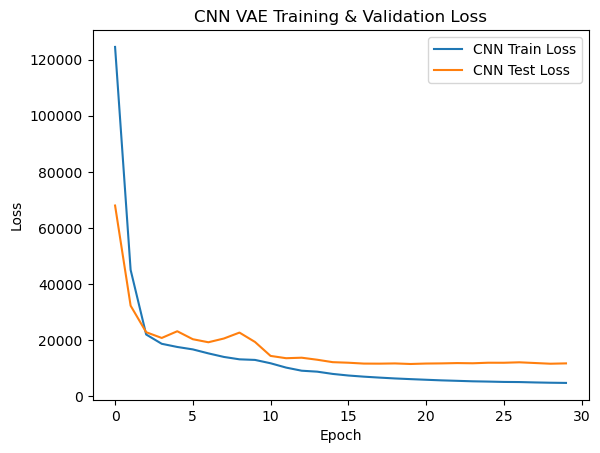

In [7]:
##############################################
# 第一阶段：训练 CNNMaskedVAE 填补缺失数据
##############################################

# 我们假设已有 CNNMaskedVAE 和 NaNMaskedVAE（多通道包装器）的定义，训练流程如下：
input_dim = len(column_names)  # 例如从 column_names 计算
hidden_dim = 256  
latent_dim = 10  
batch_size = 32
epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 初始化用于缺失填补的模型（CNNMaskedVAE 封装在 NaNMaskedVAE 中）
cnn_vae = NaNMaskedVAE(input_dim, hidden_dim, latent_dim, seq_length).to(device)
optimizer_cnn = torch.optim.Adam(cnn_vae.parameters(), lr=1e-3)

# 训练 CNN VAE（填补模型）
best_test_loss = float('inf')
patience = 10
patience_counter = 0
train_losses_cnn = []
test_losses_cnn = []

for epoch in range(1, epochs + 1):
    train_loss = train(cnn_vae, train_loader, optimizer_cnn, device)
    test_loss = test(cnn_vae, test_loader, device)
    train_losses_cnn.append(train_loss)
    test_losses_cnn.append(test_loss)
    print(f"[CNN VAE] Epoch {epoch}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        patience_counter = 0
        # torch.save(cnn_vae.state_dict(), "best_cnn_vae.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered for CNN VAE!")
            break

# 可选：保存或绘制训练曲线
plt.plot(train_losses_cnn, label="CNN Train Loss")
plt.plot(test_losses_cnn, label="CNN Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("CNN VAE Training & Validation Loss")
plt.show()

In [8]:
##############################################
# 利用训练好的 CNNMaskedVAE 填补原始数据
##############################################
def impute_dataset(model, dataset, device):
    """
    对 dataset 中的每个样本，用 model 填补缺失值（NaN），返回新的数据列表，保持原有标签。
    这里对每个样本，我们用模型的 forward 计算重构结果，然后：
      对每个位置：若原始值为 NaN，则用重构值替换，否则保留原值。
    """
    model.eval()
    imputed_samples = []
    for i in range(len(dataset)):
        x, label = dataset[i]  # x: (input_dim, seq_length)
        x_tensor = x.to(device)
        # 增加 batch 维度: (1, input_dim, seq_length)
        x_tensor = x_tensor.unsqueeze(0)
        with torch.no_grad():
            recon, _, _ = model(x_tensor)  # recon: (1, input_dim, seq_length)
        # 用重构结果填补缺失值：torch.where(条件, 值为 True 时, 值为 False 时)
        # 这里，条件为 torch.isnan(x_tensor)
        x_imputed = torch.where(torch.isnan(x_tensor), recon, x_tensor)
        # 去掉 batch 维度，并转回 CPU
        imputed_samples.append((x_imputed.squeeze(0).cpu(), label))
    return imputed_samples

# 使用原来的 train_dataset 和 test_dataset（保持最早的划分）
imputed_train_dataset = impute_dataset(cnn_vae, train_dataset, device)
imputed_test_dataset = impute_dataset(cnn_vae, test_dataset, device)

# 创建新的 DataLoader（保持原来的 batch_size）
imputed_train_loader = DataLoader(imputed_train_dataset, batch_size=batch_size, shuffle=True)
imputed_test_loader = DataLoader(imputed_test_dataset, batch_size=batch_size, shuffle=False)

Epoch 1, Train Loss: 72811.4679, Test Loss: 74741.4107
Epoch 2, Train Loss: 91466.3315, Test Loss: 67102.5918
Epoch 3, Train Loss: 56066.2001, Test Loss: 51817.1046
Epoch 4, Train Loss: 39560.8967, Test Loss: 31616.0855
Epoch 5, Train Loss: 22305.2645, Test Loss: 15207.9069
Epoch 6, Train Loss: 11461.4777, Test Loss: 16954.6805
Epoch 7, Train Loss: 11800.5603, Test Loss: 16589.0006
Epoch 8, Train Loss: 10353.0253, Test Loss: 6727.6607
Epoch 9, Train Loss: 5753.2481, Test Loss: 3839.0413
Epoch 10, Train Loss: 3417.8393, Test Loss: 1735.5154
Epoch 11, Train Loss: 1709.0252, Test Loss: 1053.7100
Epoch 12, Train Loss: 1078.5525, Test Loss: 911.6925
Epoch 13, Train Loss: 825.7873, Test Loss: 936.4959
Epoch 14, Train Loss: 714.8869, Test Loss: 360.8931
Epoch 15, Train Loss: 459.7494, Test Loss: 284.6779
Epoch 16, Train Loss: 373.3245, Test Loss: 223.9147
Epoch 17, Train Loss: 363.1066, Test Loss: 176.7734
Epoch 18, Train Loss: 300.9364, Test Loss: 156.6601
Epoch 19, Train Loss: 274.3263, Tes

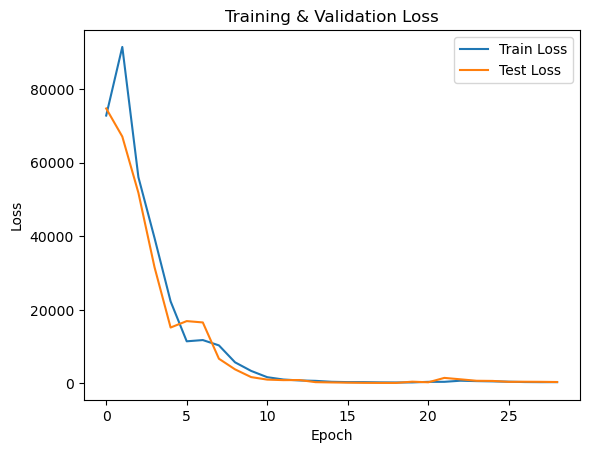

In [9]:
##############################################
# 第二阶段：用填补后的数据训练 HMM-VAE 模型
##############################################

HMM_model = HMM_NaNMaskedVAE(input_dim, hidden_dim, latent_dim, seq_length).to(device)
optimizer = torch.optim.Adam(HMM_model.parameters(), lr=1e-3)
    
# Train and test
best_test_loss = float('inf')
patience_counter = 0
    
train_losses = []
test_losses = []

for epoch in range(1, epochs + 1):
    train_loss = HMM_train(HMM_model, imputed_train_loader, optimizer, device)
    test_loss = HMM_test(HMM_model, imputed_test_loader, device)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

    # 早停逻辑
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        patience_counter = 0
        # 如果需要的话，可以在这里保存模型
        # torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

# Plot training curves
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()


In [10]:
torch.save(cnn_vae.state_dict(), "cnn_vae_final.pth")
torch.save(HMM_model.state_dict(), "HMM_model_final.pth")

In [11]:
model=HMM_model

from torch.utils.data import ConcatDataset

# 将 train_dataset 和 test_dataset 合并为一个数据集
combined_dataset = ConcatDataset([train_dataset, test_dataset])

# 如果你想用之前的 impute_dataset 函数对合并后的数据进行填补：
imputed_combined_dataset = impute_dataset(cnn_vae, combined_dataset, device)

# 然后你可以用这个新数据集创建 DataLoader
combined_loader = DataLoader(imputed_combined_dataset, batch_size=batch_size, shuffle=True)

🔍 Detected 4 EEG channels.


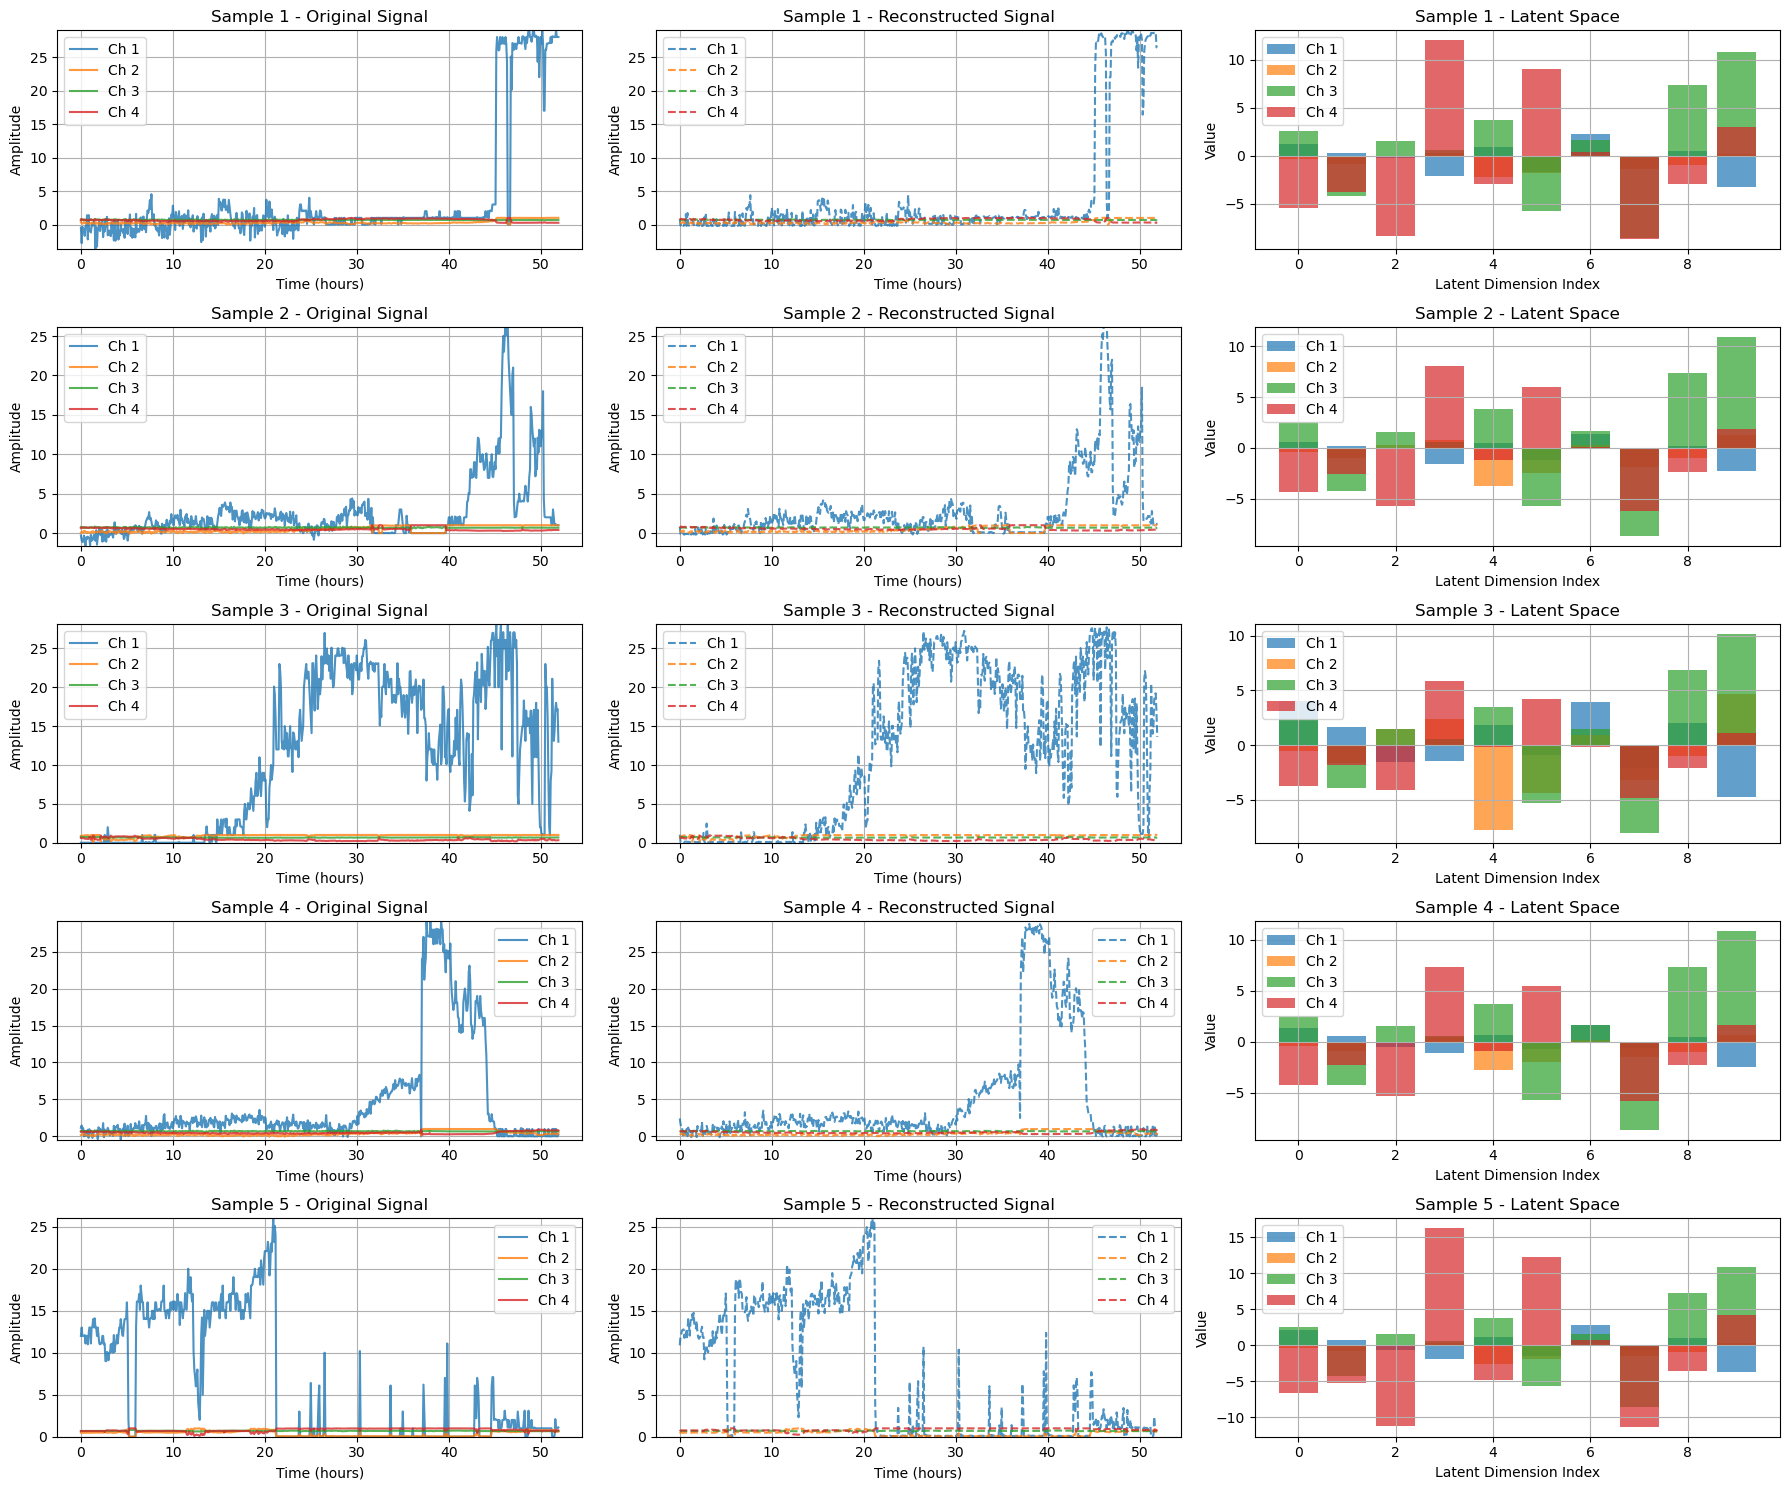

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random

def check_reconstruction(model, dataloader, device, num_samples=3):
    """
    可视化 VAE 生成的 EEG 重建数据，以及 `latent space`
    
    参数:
    - model: 训练好的 VAE 模型
    - dataloader: 数据加载器
    - device: 设备（CPU 或 GPU）
    - num_samples: 需要可视化的样本数
    """
    model.eval()  # 将模型设为评估模式

    # 获取 EEG 通道数
    num_channels = dataloader.dataset[0][0].shape[0]  # (num_channels, seq_length)
    print(f"🔍 Detected {num_channels} EEG channels.")

    # 创建画布
    fig, axes = plt.subplots(num_samples, 3, figsize=(18, 3 * num_samples))
    axes = np.atleast_2d(axes)  # 确保 axes 是二维，避免单样本时出错

    # 从数据加载器中随机选择一个批次
    for batch_idx, (x, _) in enumerate(dataloader):  # 忽略标签
        x = x.to(device)  # 将数据移动到设备上

        # 通过 VAE 进行批量重建
        with torch.no_grad():
            recon_x, mu, _ = model(x)  # 直接处理多通道数据

        # 随机选择样本进行可视化
        indices = torch.randperm(x.size(0))[:num_samples]  # 随机选择样本索引
        for i, idx in enumerate(indices):
            # 生成时间轴
            time_axis = np.linspace(0, (x.shape[2] - 1) * 5 / 60, x.shape[2])

            # 获取所有通道的最小和最大值（用于匹配 y 轴范围）
            all_min, all_max = float('inf'), float('-inf')
            for ch in range(num_channels):
                original_data = x[idx, ch].cpu().numpy()
                original_data = np.nan_to_num(original_data, nan=0.0)
                all_min = min(all_min, np.min(original_data))
                all_max = max(all_max, np.max(original_data))

            # **(1) 原始信号**
            for ch in range(num_channels):
                original_data = x[idx, ch].cpu().numpy()
                original_data = np.nan_to_num(original_data, nan=0.0)  # 将 NaN 替换为 0
                
                axes[i, 0].plot(time_axis, original_data, label=f"Ch {ch+1}", alpha=0.8)
            
            axes[i, 0].set_title(f"Sample {i+1} - Original Signal")
            axes[i, 0].set_xlabel("Time (hours)")
            axes[i, 0].set_ylabel("Amplitude")
            axes[i, 0].legend()
            axes[i, 0].grid(True)
            axes[i, 0].set_ylim(all_min, all_max)

            # **(2) 重建信号**
            for ch in range(num_channels):
                axes[i, 1].plot(time_axis, recon_x[idx, ch].cpu().numpy().squeeze(),
                                label=f"Ch {ch+1}", linestyle="dashed", alpha=0.8)
            
            axes[i, 1].set_title(f"Sample {i+1} - Reconstructed Signal")
            axes[i, 1].set_xlabel("Time (hours)")
            axes[i, 1].set_ylabel("Amplitude")
            axes[i, 1].legend()
            axes[i, 1].grid(True)
            axes[i, 1].set_ylim(all_min, all_max)  # 使 y 轴范围与原始信号匹配

            # **(3) Latent Space**
            for ch in range(num_channels):
                axes[i, 2].bar(range(len(mu[idx, ch].cpu().numpy())), mu[idx, ch].cpu().numpy(), alpha=0.7, label=f"Ch {ch+1}")
            axes[i, 2].set_title(f"Sample {i+1} - Latent Space")
            axes[i, 2].set_xlabel("Latent Dimension Index")
            axes[i, 2].set_ylabel("Value")
            axes[i, 2].legend()
            axes[i, 2].grid(True)

        break  # 只检查一个批次

    # 调整布局并保存图像
    plt.tight_layout()
    plt.savefig("vae_reconstruction_check.png")  # 保存图像
    plt.show()
    
# Check reconstruction results
check_reconstruction(model, imputed_test_loader, device, num_samples=5)

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random

def extract_latent_features(vae_model, dataset):
    """
    提取多通道 VAE 的 latent features，并进行归一化
    
    参数:
    - vae_model: 训练好的多通道 VAE
    - dataset: EEG 数据集

    返回:
    - normalized_latent_features: (batch_size, num_channels * latent_dim) 归一化后的特征
    - labels: 样本对应的标签
    """
    latent_features = []
    labels = []
    num_eeg_channels = vae_model.input_dim  # 🚀 确保与模型通道数匹配
    
    # 进入评估模式
    vae_model.eval()
    
    with torch.no_grad():
        for i in range(len(dataset)):
            signal, label = dataset[i]
            
            if isinstance(signal, torch.Tensor):
                signal = signal.to(device)  # 🚀 (num_channels, seq_length)
            else:
                signal = torch.tensor(signal, dtype=torch.float32).to(device)
            
            # 获取多通道 latent vectors
            latent_vector = vae_model.get_embedding(signal.unsqueeze(0))  # 🚀 直接批量提取 embedding
            
            latent_features.append(latent_vector.cpu().numpy().flatten())  # 🚀 拼接通道 latent vectors
            labels.append(label)
    
    latent_features = np.array(latent_features)  # 🚀 (num_samples, num_channels * latent_dim)
    
    # 🚀 **对 `latent feature` 进行 normalize**
    mean = np.mean(latent_features, axis=0, keepdims=True)  # 🚀 计算均值
    std = np.std(latent_features, axis=0, keepdims=True)  # 🚀 计算标准差
    std[std == 0] = 1e-8  # 防止除以 0
    normalized_latent_features = (latent_features - mean) / std  # 🚀 z-score 归一化
    
    print(f"✅ Feature extraction complete! Extracted {len(normalized_latent_features)} samples.")
    return normalized_latent_features, np.array(labels)

In [14]:
import torch
import numpy as np

def extract_latent_features(vae_model, dataset):
    """
    提取多通道 VAE 的 latent features，并对每个通道单独归一化
    
    参数:
    - vae_model: 训练好的 NaNMaskedVAE
    - dataset: EEG 数据集
    - device: 设备（CPU 或 GPU）

    返回:
    - normalized_latent_features: (batch_size, num_channels * latent_dim) 归一化后的特征
    - labels: 样本对应的标签
    """
    latent_features = []
    labels = []
    num_eeg_channels = vae_model.input_dim  # 需要匹配模型的输入通道数

    # 进入评估模式
    vae_model.eval()

    with torch.no_grad():
        for i in range(len(dataset)):
            signal, label = dataset[i]

            if isinstance(signal, torch.Tensor):
                signal = signal.to(device)  # (num_channels, seq_length)
            else:
                signal = torch.tensor(signal, dtype=torch.float32).to(device)

            # 获取多通道 latent vectors
            latent_vector = vae_model.get_embedding(signal.unsqueeze(0))  # (1, num_channels, latent_dim)

            latent_vector = latent_vector.cpu().numpy().squeeze(0)  # (num_channels, latent_dim)

            # 🚀 **对每个通道的 latent feature 进行独立归一化**
            for ch in range(num_eeg_channels):
                mean = np.mean(latent_vector[ch], keepdims=True)  # 计算该通道的均值
                std = np.std(latent_vector[ch], keepdims=True)  # 计算该通道的标准差
                std[std == 0] = 1e-8  # 防止除以 0

                latent_vector[ch] = (latent_vector[ch] - mean) / std  # z-score 归一化

            # **拼接所有通道的归一化特征**
            latent_features.append(latent_vector.flatten())  # (num_channels * latent_dim,)
            labels.append(label)

    # 转换为 numpy 数组
    normalized_latent_features = np.array(latent_features)  # (num_samples, num_channels * latent_dim)
    
    print(f"✅ Feature extraction complete! Extracted {len(normalized_latent_features)} samples.")

    return normalized_latent_features, np.array(labels)

In [15]:
# Assuming you have a list of trained VAE models (one for each EEG channel)
vae_models = model # Replace with your trained models

# Extract latent features
latent_features, labels = extract_latent_features(vae_models, imputed_combined_dataset)

✅ Feature extraction complete! Extracted 243 samples.


In [16]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D

# 🚀 1️⃣ 可视化 `latent feature` 作为 Heatmap
def visualize_latent_heatmap(latent_features, labels):
    """
    用 Heatmap 可视化 `latent feature`，适用于直接查看特征分布。

    参数：
    - latent_features: 2D numpy array, 形状为 (样本数, 特征维度)
    - labels: 1D numpy array, 样本标签
    """
    plt.figure(figsize=(12, 8))
    sns.heatmap(latent_features, cmap='coolwarm', center=0, xticklabels=False, yticklabels=False)
    plt.title("Latent Feature Heatmap")
    plt.xlabel("Latent Dimensions")
    plt.ylabel("Samples")
    plt.colorbar(label="Feature Value")
    plt.show()

# 🚀 2️⃣ PCA 降维 + 2D/3D 可视化
def visualize_pca(latent_features, labels, dimensions=2):
    """
    用 PCA 降维 `latent feature` 并进行可视化。

    参数：
    - latent_features: 2D numpy array, 形状为 (样本数, 特征维度)
    - labels: 1D numpy array, 样本标签
    - dimensions: int, 降维目标维度 (2 或 3)
    """
    pca = PCA(n_components=dimensions)
    reduced_features = pca.fit_transform(latent_features)

    color_map = {0: 'blue', 1: 'red'}
    colors = [color_map[label] for label in labels]

    if dimensions == 2:
        plt.figure(figsize=(8, 6))
        plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=colors, alpha=0.7)

        handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, alpha=0.7, label='Bad Outcome'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, alpha=0.7, label='Good Outcome')]
        plt.legend(handles=handles, title="Labels")

        plt.title("PCA Projection of Latent Space (2D)")
        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")
        plt.grid(True)
        plt.show()

    elif dimensions == 3:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        scatter = ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2], c=colors, alpha=0.7)

        handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, alpha=0.7, label='Bad Outcome'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, alpha=0.7, label='Good Outcome')]
        ax.legend(handles=handles, title="Labels")
        ax.set_title("PCA Projection of Latent Space (3D)")
        ax.set_xlabel("PCA Component 1")
        ax.set_ylabel("PCA Component 2")
        ax.set_zlabel("PCA Component 3")
        plt.show()

# 🚀 3️⃣ t-SNE 代替 `UMAP`
def visualize_tsne(latent_features, labels, dimensions=2):
    """
    用 t-SNE 降维 `latent feature` 并进行可视化。

    参数：
    - latent_features: 2D numpy array, 形状为 (样本数, 特征维度)
    - labels: 1D numpy array, 样本标签
    - dimensions: int, 降维目标维度 (2)
    """
    tsne = TSNE(n_components=dimensions, perplexity=30, random_state=42)
    reduced_features = tsne.fit_transform(latent_features)

    color_map = {0: 'blue', 1: 'red'}
    colors = [color_map[label] for label in labels]

    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=colors, alpha=0.7)

    handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, alpha=0.7, label='Bad Outcome'),
               Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, alpha=0.7, label='Good Outcome')]
    plt.legend(handles=handles, title="Labels")

    plt.title("t-SNE Projection of Latent Space (2D)")
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.grid(True)
    plt.show()

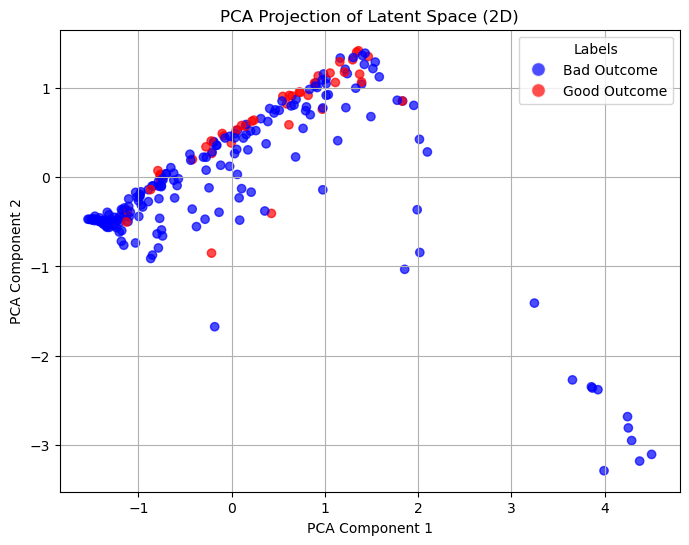

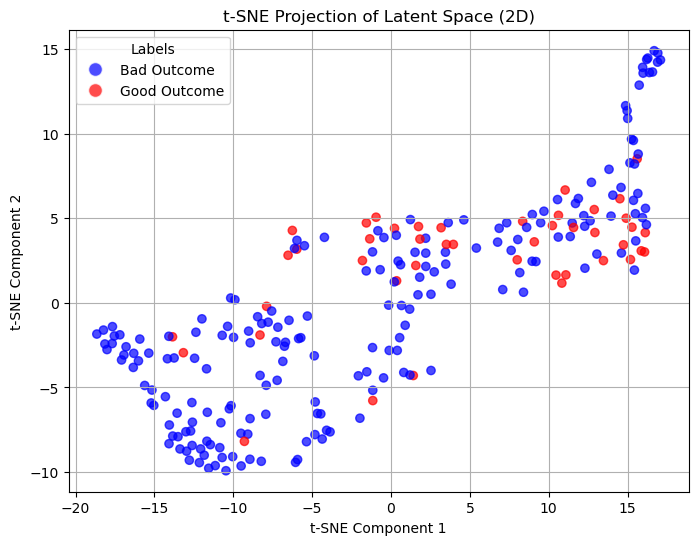

In [17]:
visualize_pca(latent_features, labels, dimensions=2)  # `PCA` 降到 `2D` 可视化
visualize_tsne(latent_features, labels, dimensions=2)  # `t-SNE` 替代 `UMAP` 可视化

In [18]:
# 🚀 提取训练集的 `latent feature`
X_train, y_train = extract_latent_features(vae_models, imputed_train_dataset)

# 🚀 提取测试集的 `latent feature`
X_test, y_test = extract_latent_features(vae_models, imputed_test_dataset)


# 🚀 确保 labels 是 numpy 数组
labels_train = np.array(y_train)
labels_test = np.array(y_test)

# 🚀 打印类别分布，检查数据是否平衡
print(f"Training set class distribution: {np.bincount(labels_train)}")
print(f"Testing set class distribution: {np.bincount(labels_test)}")

# 🚀 对训练集进行 SMOTE 过采样（仅对训练集进行操作，避免数据泄露）
smote = SMOTE(random_state=42)
smote = SMOTE(k_neighbors=2, random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)
#X_test, y_test = smote.fit_resample(X_test, y_test)
print(f"Resampled training set class distribution: {np.bincount(y_train)}")
print(f"Resampled training set class distribution: {np.bincount(y_test)}")

✅ Feature extraction complete! Extracted 194 samples.
✅ Feature extraction complete! Extracted 49 samples.
Training set class distribution: [159  35]
Testing set class distribution: [40  9]
Resampled training set class distribution: [159 159]
Resampled training set class distribution: [40  9]


C:\Users\zayin\AppData\Local\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


✅ XGB Accuracy: 0.7959
✅ XGB AUC: 0.7667

✅ XGB Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88        40
           1       0.43      0.33      0.38         9

    accuracy                           0.80        49
   macro avg       0.64      0.62      0.63        49
weighted avg       0.78      0.80      0.79        49


✅ XGB Confusion Matrix:
[[36  4]
 [ 6  3]]
Expected feature count: 40, Generated feature count: 40


C:\Users\zayin\AppData\Local\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:42:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


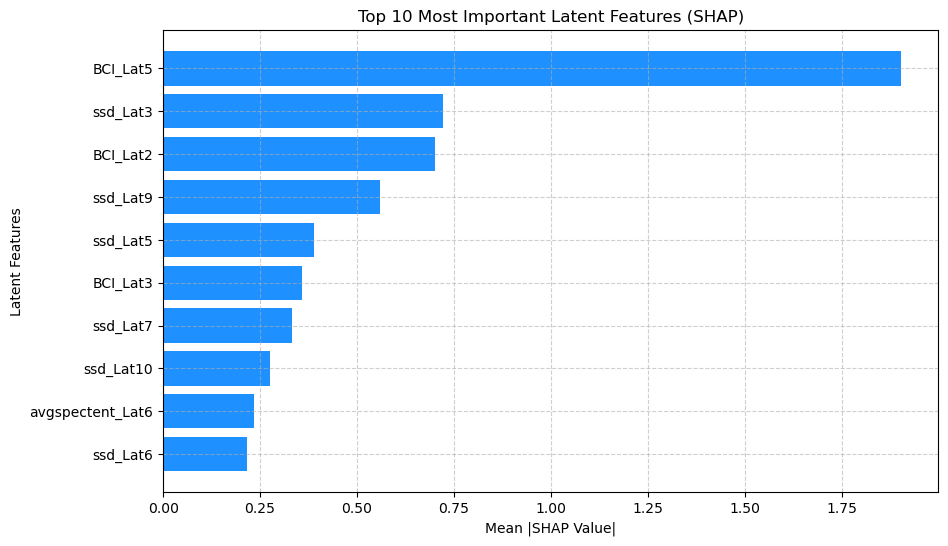

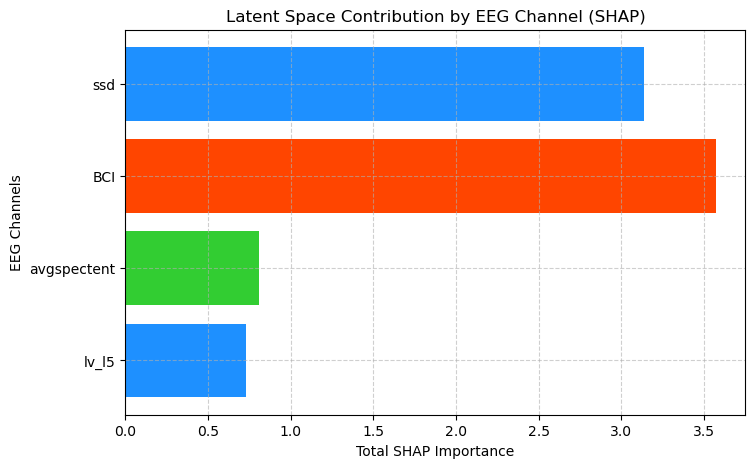

In [19]:
## 🚀 **创建 XGBoost 分类模型**
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)

# 🚀 **进行预测**
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)

# 🚀 **计算 AUC 和准确率**
auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb[:, 1])  # Use probability of the positive class
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)

print(f"✅ XGB Accuracy: {accuracy_xgb:.4f}")
print(f"✅ XGB AUC: {auc_xgb:.4f}")
print("\n✅ XGB Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("\n✅ XGB Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

# 🚀 使用 SHAP 解释模型
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)

# 🚀 画出所有 `latent feature` 的贡献
# 🚀 创建 `SHAP` 解释器
explainer = shap.TreeExplainer(xgb_model)

# 🚀 计算 `SHAP` 值
shap_values = explainer.shap_values(X_test)
# 🚀 计算特征重要性（取 SHAP 值的平均绝对值）
feature_importance = np.abs(shap_values).mean(axis=0)

# 🚀 生成特征名称
num_channels = num_eeg_channels  # 🚀 这里严格遵守变量命名
feature_names = [f"{column_names[ch]}_Lat{i+1}" for ch in range(num_channels) for i in range(latent_dim)]

# 🚀 确保 feature_names 维度正确
num_features = X_test.shape[1]
feature_names = feature_names[:num_features]

print(f"Expected feature count: {num_features}, Generated feature count: {len(feature_names)}")

# 🚀 可视化 - 方案 1：Top 10 最重要的 `latent feature`
sorted_idx = np.argsort(feature_importance)[::-1]  # 按照重要性排序
top_k = 10  # 取最重要的前 10 个特征

plt.figure(figsize=(10, 6))
plt.barh([feature_names[i] for i in sorted_idx[:top_k]], feature_importance[sorted_idx[:top_k]], color='dodgerblue')
plt.xlabel("Mean |SHAP Value|")
plt.ylabel("Latent Features")
plt.title("Top 10 Most Important Latent Features (SHAP)")
plt.gca().invert_yaxis()  # 反转 y 轴，使最重要的特征在顶部
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# 🚀 可视化 - 方案 2：按通道计算特征贡献
channel_importance = [
    np.sum(feature_importance[ch * latent_dim : (ch + 1) * latent_dim]) for ch in range(num_channels)
]

plt.figure(figsize=(8, 5))
plt.barh([f"{column_names[ch]}" for ch in range(num_channels)], channel_importance, color=['dodgerblue', 'orangered', 'limegreen'])
plt.xlabel("Total SHAP Importance")
plt.ylabel("EEG Channels")
plt.title("Latent Space Contribution by EEG Channel (SHAP)")
plt.gca().invert_yaxis()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

✅ EBM Accuracy: 0.7959
✅ EBM AUC: 0.7250

✅ EBM Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88        40
           1       0.43      0.33      0.38         9

    accuracy                           0.80        49
   macro avg       0.64      0.62      0.63        49
weighted avg       0.78      0.80      0.79        49


✅ EBM Confusion Matrix:
[[36  4]
 [ 6  3]]


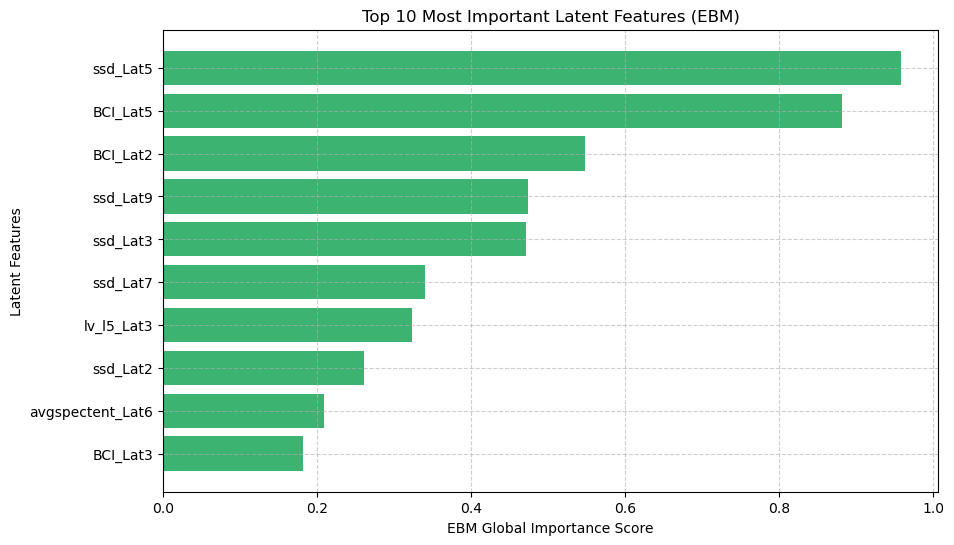

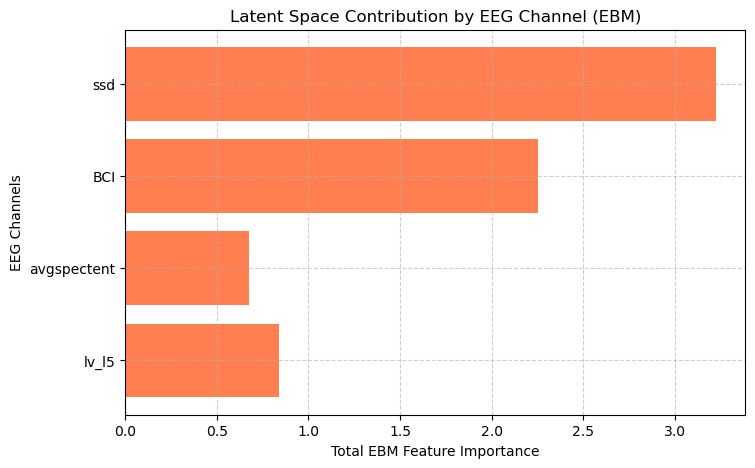

In [20]:
# ✅ 训练 EBM 模型
ebm = ExplainableBoostingClassifier(random_state=42)
ebm.fit(X_train, y_train)

# ✅ 预测结果与性能
y_pred_ebm = ebm.predict(X_test)
y_pred_proba_ebm = ebm.predict_proba(X_test)

auc_ebm = roc_auc_score(y_test, y_pred_proba_ebm[:, 1])
accuracy_ebm = accuracy_score(y_test, y_pred_ebm)

print(f"✅ EBM Accuracy: {accuracy_ebm:.4f}")
print(f"✅ EBM AUC: {auc_ebm:.4f}")
print("\n✅ EBM Classification Report:")
print(classification_report(y_test, y_pred_ebm))
print("\n✅ EBM Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_ebm))

# ✅ 提取全局解释数据
ebm_global = ebm.explain_global()
ebm_feature_names = ebm_global.data()["names"]
ebm_importances = ebm_global.data()["scores"]

# ✅ 生成你的特征名
num_features = X_test.shape[1]
feature_names = [f"{column_names[ch]}_Lat{i+1}" for ch in range(num_eeg_channels) for i in range(latent_dim)]
feature_names = feature_names[:num_features]

# ✅ 映射 EBM feature_0001 -> feature_names[]
import re

def extract_index(feat_name):
    # 只匹配类似 "feature_0032" 的单个特征
    match = re.fullmatch(r"feature_(\d+)", feat_name)
    if match:
        return int(match.group(1))
    return None  # 是交互项，跳过

mapped_names = []
mapped_importances = []
for feat, score in zip(ebm_feature_names, ebm_importances):
    idx = extract_index(feat)
    if idx is not None and idx < len(feature_names):
        mapped_names.append(feature_names[idx])
        mapped_importances.append(score)

# ✅ 可视化 Top 10 latent feature
sorted_idx = np.argsort(mapped_importances)[::-1]
top_k = 10

plt.figure(figsize=(10, 6))
plt.barh(
    [mapped_names[i] for i in sorted_idx[:top_k]],
    [mapped_importances[i] for i in sorted_idx[:top_k]],
    color='mediumseagreen'
)
plt.xlabel("EBM Global Importance Score")
plt.ylabel("Latent Features")
plt.title("Top 10 Most Important Latent Features (EBM)")
plt.gca().invert_yaxis()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# ✅ 通道级别的贡献汇总
channel_importance = [
    sum(
        mapped_importances[i]
        for i in range(len(mapped_names))
        if mapped_names[i].startswith(f"{column_names[ch]}_Lat")
    )
    for ch in range(num_eeg_channels)
]

plt.figure(figsize=(8, 5))
plt.barh(
    [f"{column_names[ch]}" for ch in range(num_eeg_channels)],
    channel_importance,
    color='coral'
)
plt.xlabel("Total EBM Feature Importance")
plt.ylabel("EEG Channels")
plt.title("Latent Space Contribution by EEG Channel (EBM)")
plt.gca().invert_yaxis()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

✅ CatBoost Accuracy: 0.7959
✅ CatBoost AUC: 0.7833

✅ CatBoost Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88        40
           1       0.43      0.33      0.38         9

    accuracy                           0.80        49
   macro avg       0.64      0.62      0.63        49
weighted avg       0.78      0.80      0.79        49


✅ CatBoost Confusion Matrix:
[[36  4]
 [ 6  3]]


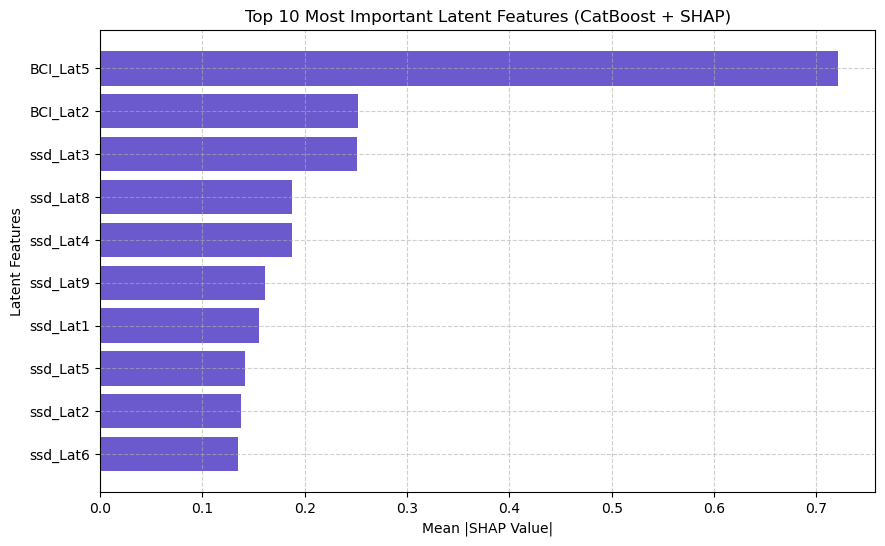

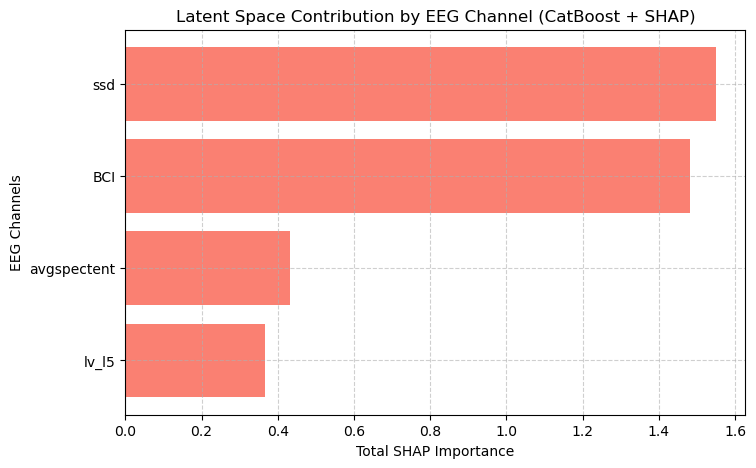

In [21]:
# ✅ 训练 CatBoost 模型
cat_model = CatBoostClassifier(verbose=0, random_seed=42)
cat_model.fit(X_train, y_train)

# ✅ 预测与评估
y_pred_cat = cat_model.predict(X_test)
y_pred_proba_cat = cat_model.predict_proba(X_test)

auc_cat = roc_auc_score(y_test, y_pred_proba_cat[:, 1])
accuracy_cat = accuracy_score(y_test, y_pred_cat)

print(f"✅ CatBoost Accuracy: {accuracy_cat:.4f}")
print(f"✅ CatBoost AUC: {auc_cat:.4f}")
print("\n✅ CatBoost Classification Report:")
print(classification_report(y_test, y_pred_cat))
print("\n✅ CatBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_cat))

# ✅ 计算 SHAP 值
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X_test)
feature_importance = np.abs(shap_values).mean(axis=0)

# ✅ 生成特征名
num_features = X_test.shape[1]
feature_names = [f"{column_names[ch]}_Lat{i+1}" for ch in range(num_eeg_channels) for i in range(latent_dim)]
feature_names = feature_names[:num_features]

# ✅ 可视化 Top 10 最重要 latent 特征
sorted_idx = np.argsort(feature_importance)[::-1]
top_k = 10

plt.figure(figsize=(10, 6))
plt.barh(
    [feature_names[i] for i in sorted_idx[:top_k]],
    feature_importance[sorted_idx[:top_k]],
    color='slateblue'
)
plt.xlabel("Mean |SHAP Value|")
plt.ylabel("Latent Features")
plt.title("Top 10 Most Important Latent Features (CatBoost + SHAP)")
plt.gca().invert_yaxis()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# ✅ 按通道聚合 SHAP 贡献
channel_importance = [
    np.sum(feature_importance[ch * latent_dim : (ch + 1) * latent_dim])
    for ch in range(num_eeg_channels)
]

plt.figure(figsize=(8, 5))
plt.barh(
    [column_names[ch] for ch in range(num_eeg_channels)],
    channel_importance,
    color='salmon'
)
plt.xlabel("Total SHAP Importance")
plt.ylabel("EEG Channels")
plt.title("Latent Space Contribution by EEG Channel (CatBoost + SHAP)")
plt.gca().invert_yaxis()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [22]:
def run_clustering_analysis(latent_features, labels, method='kmeans', min_clusters=2, max_clusters=10):
    silhouette_scores = []
    cluster_models = []

    for k in range(min_clusters, max_clusters):
        if method == 'kmeans':
            model = KMeans(n_clusters=k, random_state=42, n_init=10)
        elif method == 'gmm':
            model = GaussianMixture(n_components=k, random_state=42)
        elif method == 'agglo':
            model = AgglomerativeClustering(n_clusters=k)
        elif method == 'spectral':
            model = SpectralClustering(n_clusters=k, assign_labels='kmeans', random_state=42)
        else:
            raise ValueError("Unsupported clustering method.")
        
        cluster_labels = model.fit_predict(latent_features)
        score = silhouette_score(latent_features, cluster_labels)
        silhouette_scores.append(score)
        cluster_models.append((model, cluster_labels))

    optimal_idx = int(np.argmax(silhouette_scores))
    optimal_clusters = min_clusters + optimal_idx
    best_model, best_labels = cluster_models[optimal_idx]

    contingency_table = np.zeros((optimal_clusters, 2))
    group_good_bad_ratios = []

    for i in range(optimal_clusters):
        n_bad = np.sum((best_labels == i) & (labels == 0))
        n_good = np.sum((best_labels == i) & (labels == 1))
        contingency_table[i, 0] = n_bad
        contingency_table[i, 1] = n_good
        ratio = n_good / (n_bad + 1e-6)
        group_good_bad_ratios.append(ratio)
        print(f"✅ Cluster {i+1}: Good Count = {n_good}, Bad Count = {n_bad}, Good/Bad Ratio = {ratio:.4f}")

 
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    global_good = np.sum(labels == 1)
    global_bad = np.sum(labels == 0)
    global_ratio = global_good / (global_bad + 1e-6)
    t_stat, t_p_value = ttest_ind(group_good_bad_ratios, np.full_like(group_good_bad_ratios, global_ratio))

    # Silhouette plot
    plt.figure(figsize=(8, 6))
    plt.plot(range(min_clusters, max_clusters), silhouette_scores, marker='o', linestyle='--', color='b')
    plt.axvline(optimal_clusters, linestyle="--", color="r", label=f"Optimal K = {optimal_clusters}")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Score")
    plt.title(f"Silhouette Score vs Number of Clusters ({method})")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(contingency_table, annot=True, cmap="coolwarm", fmt=".0f",
                xticklabels=["Bad", "Good"],
                yticklabels=[f"Cluster {i+1}" for i in range(optimal_clusters)])
    plt.xlabel("Outcome")
    plt.ylabel("Cluster")
    plt.title("Outcome Distribution per Cluster")
    plt.show()

    # PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(latent_features)

    plt.figure(figsize=(8, 6))
    for i in range(optimal_clusters):
        mask = best_labels == i
        plt.scatter(pca_result[mask, 0], pca_result[mask, 1], label=f"Cluster {i+1}", alpha=0.7)
    plt.legend()
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.title("PCA Projection of Clusters")
    plt.grid(True)
    plt.show()

    return best_labels, optimal_clusters, contingency_table, group_good_bad_ratios, global_ratio, chi2, p, dof, expected, t_stat, t_p_value


C:\Users\zayin\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\zayin\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\zayin\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\zayin\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: User

✅ Cluster 1: Good Count = 12, Bad Count = 112, Good/Bad Ratio = 0.1071
✅ Cluster 2: Good Count = 0, Bad Count = 11, Good/Bad Ratio = 0.0000
✅ Cluster 3: Good Count = 32, Bad Count = 76, Good/Bad Ratio = 0.4211


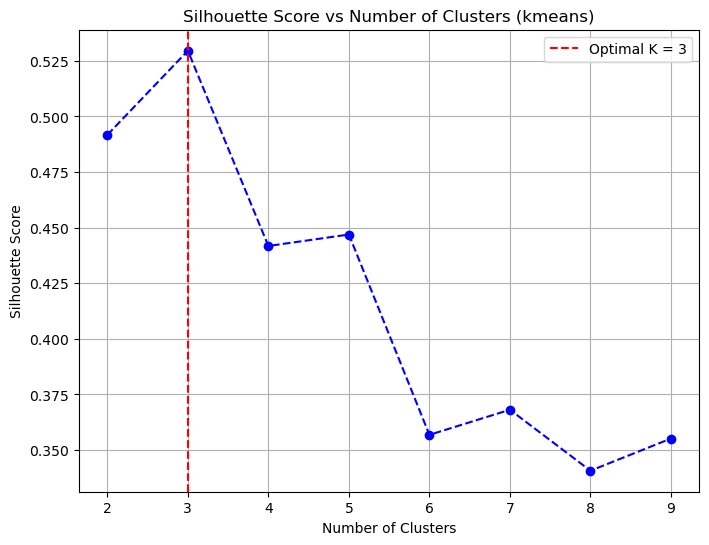

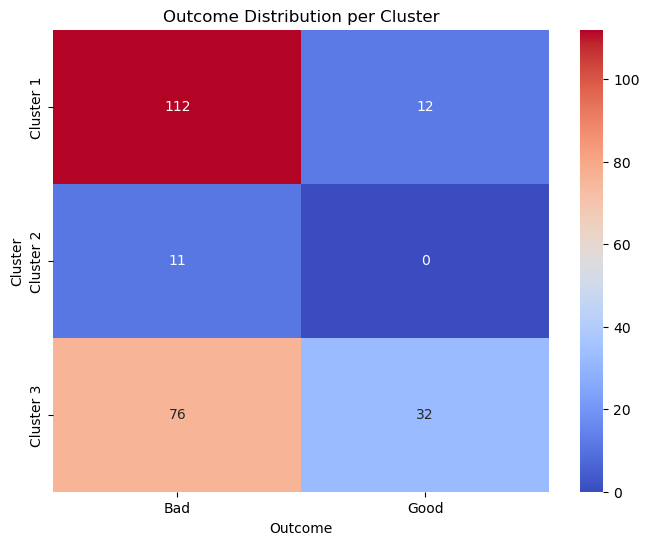

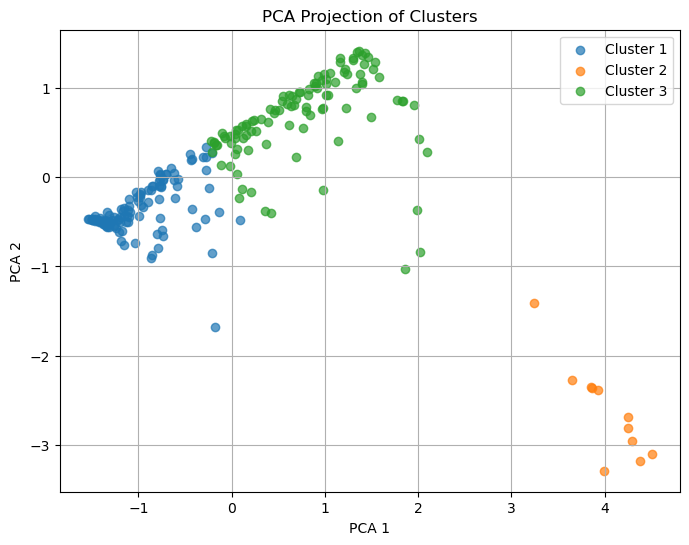

In [23]:
cluster_labels, optimal_clusters, contingency_table, group_ratios, global_ratio, chi2, p, dof, expected, t_stat, t_p = run_clustering_analysis(
    latent_features, labels, method='kmeans'  # 支持 'kmeans', 'gmm', 'agglo', 'spectral'
)

C:\Users\zayin\AppData\Local\Temp\ipykernel_22640\989686219.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


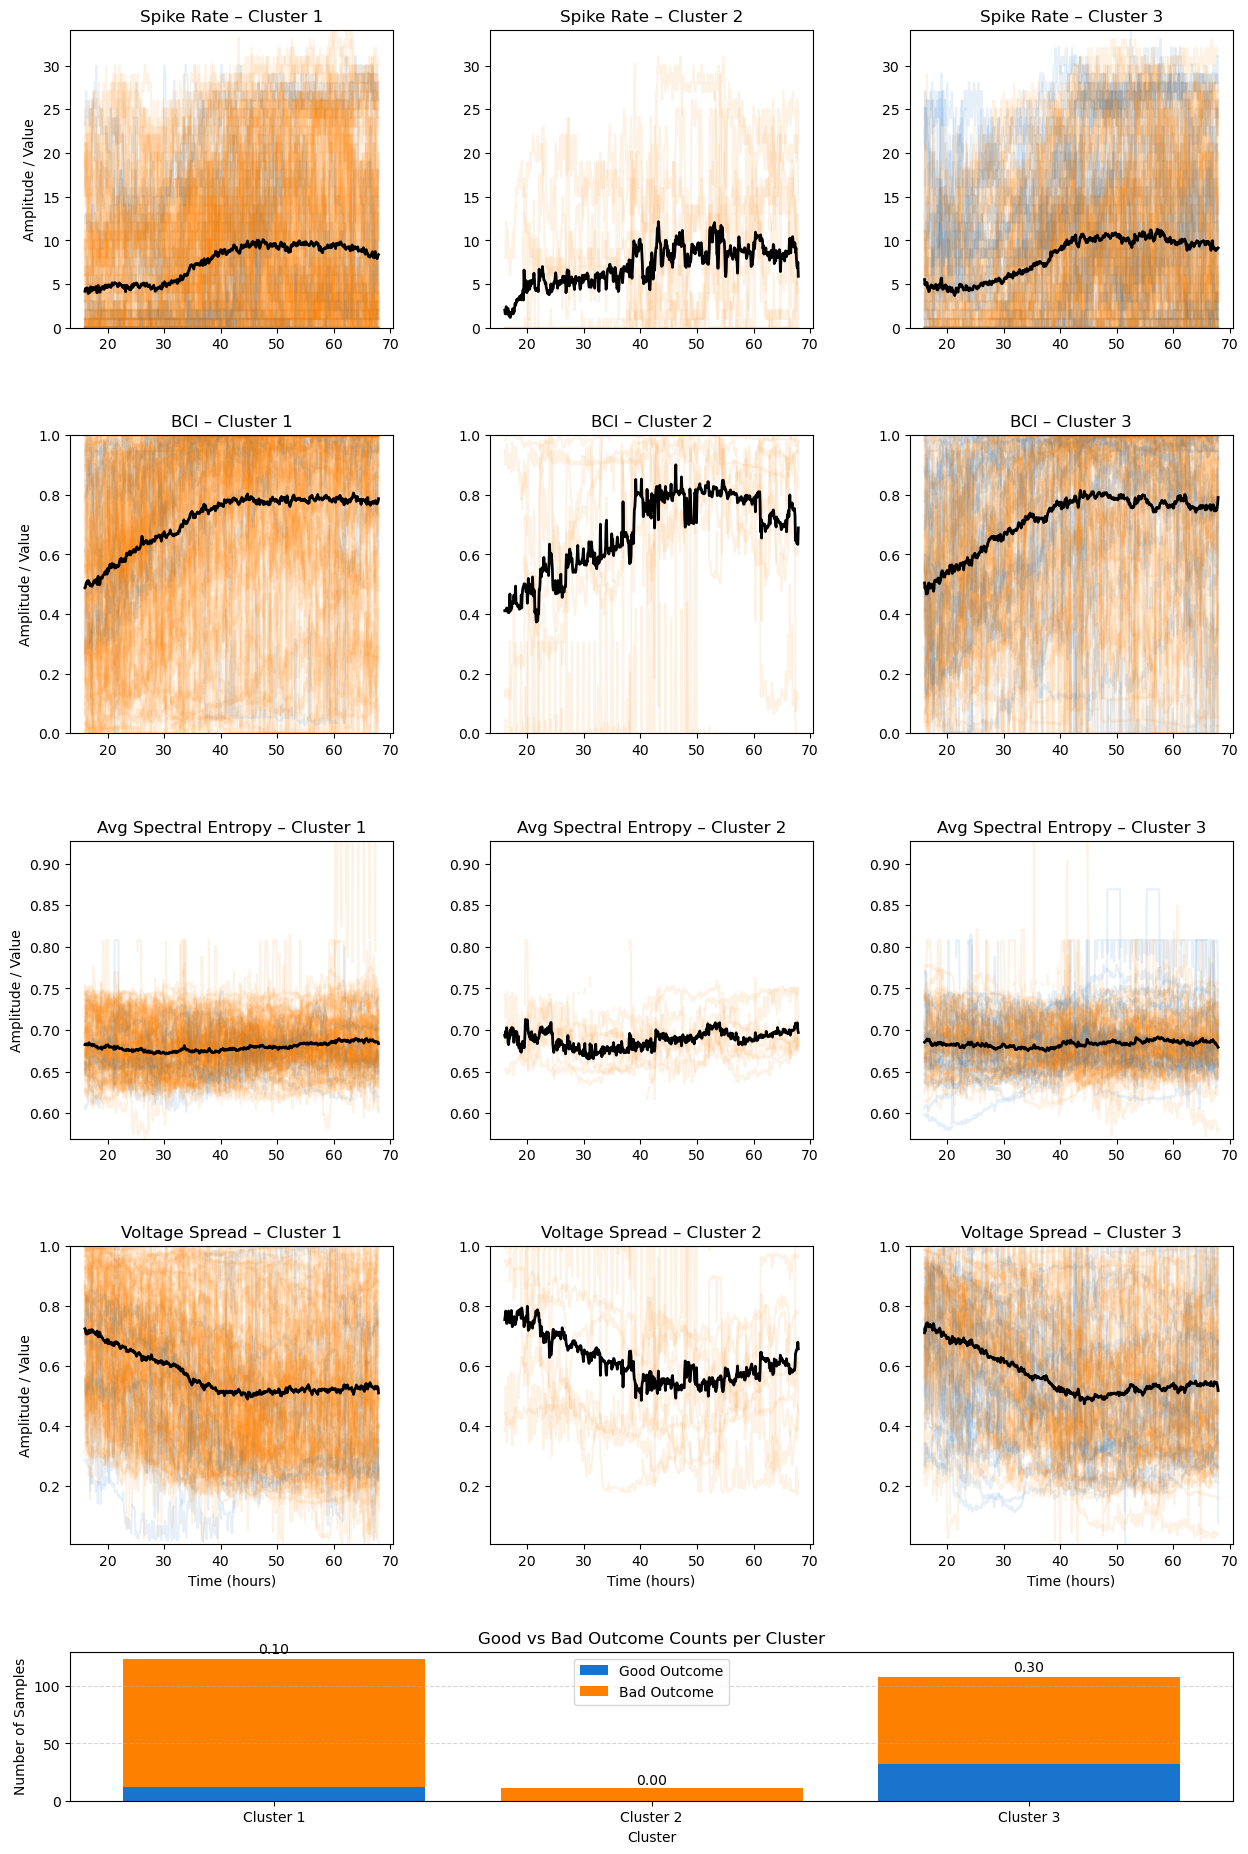

In [26]:
# 🚀 获取原始 EEG 数据
raw_data = np.array([eeg_dataset_1[i][0].numpy() for i in range(len(eeg_dataset_1))])  # (n_samples, num_channels, time_steps)

# **时间轴处理**
time_per_step = 5/60  # 每个时间步为 5 分钟（小时）
time_axis = np.arange(raw_data.shape[2]) * time_per_step + start_time

# 🚀 全局 y 轴范围（只忽略 NaN）
min_values = np.nanmin(raw_data, axis=(0, 2))
max_values = np.nanmax(raw_data, axis=(0, 2))

# 布局参数
rows = num_channels + 1                # EEG 子图 + 1 行用于柱状图
cols = optimal_clusters
height_ratios = [1]*num_channels + [0.5]  # 底部柱状图行高度是单行 EEG 的一半

fig_width  = 5 * cols
fig_height = 5 * num_channels + 3        # 额外留约 3 英寸给底部柱状图
fig = plt.figure(figsize=(fig_width, fig_height))

gs = GridSpec(rows, cols, figure=fig,
              height_ratios=height_ratios,
              hspace=0.4, wspace=0.3)
column_names=['Spike Rate', 'BCl', 'Avg Spectral Entropy', 'Voltage Spread']
# Good/Bad 颜色
color_good = '#1974CD'
color_bad  = '#FE8000'

# — EEG 子图 —
for ch in range(num_channels):
    for i in range(cols):
        ax = fig.add_subplot(gs[ch, i])
        mask = (cluster_labels == i)
        # 背景样本曲线
        for sample, lab in zip(raw_data[mask, ch, :], labels[mask]):
            c = color_good if lab == 1 else color_bad
            ax.plot(time_axis, sample, color=c, alpha=0.1)
        # 均值曲线
        mean_curve = np.nanmean(raw_data[mask, ch, :], axis=0)
        ax.plot(time_axis, mean_curve, color='black', linewidth=2)
        # 标题 & 标签
        ax.set_title(f"{column_names[ch]} – Cluster {i+1}")
        if i == 0:
            ax.set_ylabel("Amplitude / Value")
        if ch == num_channels - 1:
            ax.set_xlabel("Time (hours)")
        ax.set_ylim(min_values[ch], max_values[ch])
        ax.grid(False)

# — 底部堆叠柱状图（跨所有列） —
bar_ax = fig.add_subplot(gs[num_channels, :])
good_counts = [int(np.sum((cluster_labels == i) & (labels == 1))) for i in range(cols)]
bad_counts  = [int(np.sum((cluster_labels == i) & (labels == 0))) for i in range(cols)]
cluster_names = [f"Cluster {i+1}" for i in range(cols)]

bars_good = bar_ax.bar(cluster_names, good_counts, color=color_good, label='Good Outcome')
bars_bad  = bar_ax.bar(cluster_names, bad_counts,  bottom=good_counts, color=color_bad,  label='Bad Outcome')

bar_ax.set_xlabel('Cluster')
bar_ax.set_ylabel('Number of Samples')
bar_ax.set_title('Good vs Bad Outcome Counts per Cluster')
bar_ax.legend()
bar_ax.grid(axis='y', linestyle='--', alpha=0.5)

# 在每个柱子上方标注 ratio
# 在每个柱子上方标注 ratio（稍微高一点）
for i, (g, b) in enumerate(zip(good_counts, bad_counts)):
    total = g + b
    ratio = g / total if total > 0 else 0
    y = total * 1.02  # 比总高度再往上 2%
    bar_ax.text(i, y, f"{ratio:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()

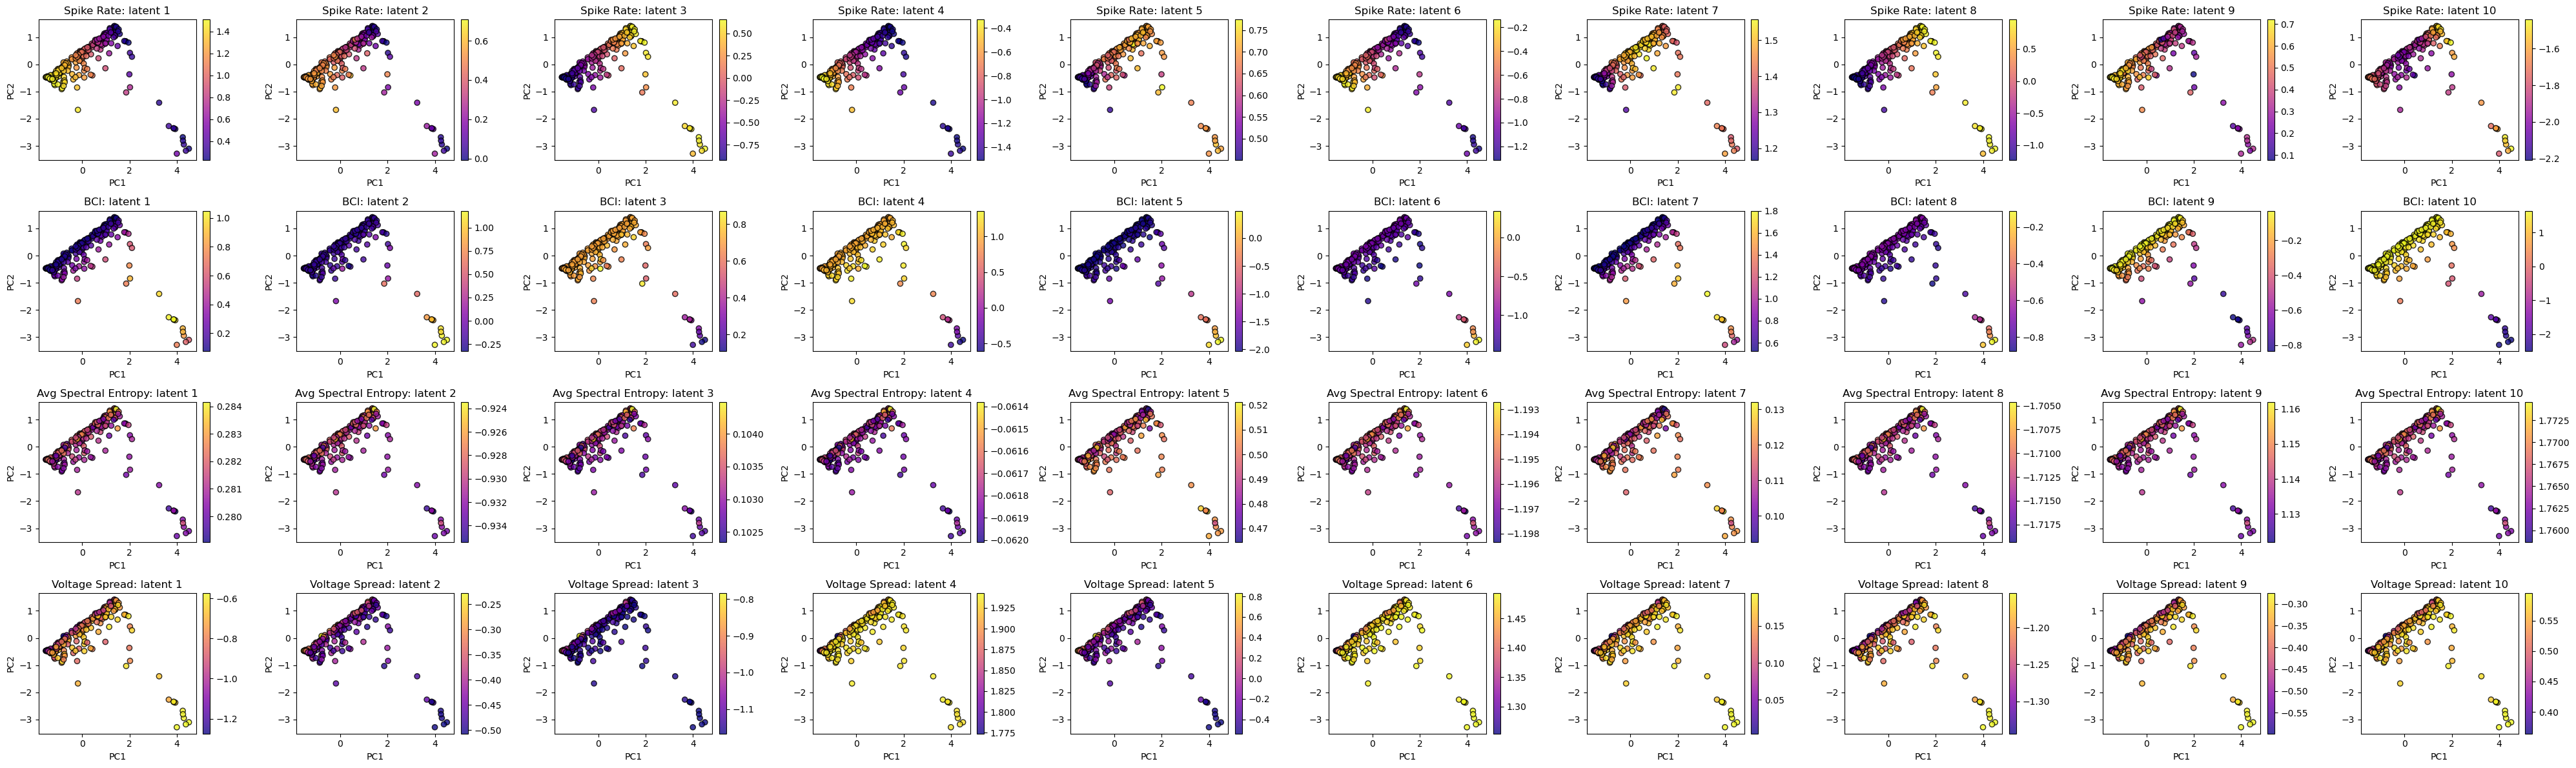

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 假设 latent_features 的 shape 为 (n_samples, num_channels * latent_dim)
# column_names: 各 feature（如 EEG 通道）名称列表
# 例如:
#   latent_features = ...  # 已有数据，形状为 (n_samples, num_channels * latent_dim)
#   column_names = ['Channel1', 'Channel2', 'Channel3']
#   latent_dim = 10

n_samples, total_dim = latent_features.shape
num_channels = len(column_names)
latent_dim = total_dim // num_channels

# 1. 利用 PCA 将高维数据降到 2D（用于整体数据分布展示）
pca = PCA(n_components=2)
X_pca = pca.fit_transform(latent_features)

# 2. 创建子图，行数 = num_channels, 列数 = latent_dim
fig, axes = plt.subplots(num_channels, latent_dim, figsize=(latent_dim * 4, num_channels * 3), squeeze=False)

for ch in range(num_channels):
    for ld in range(latent_dim):
        # 对于每个 feature 的每个 latent 维度，计算索引位置
        idx = ch * latent_dim + ld
        # 提取当前维度的值
        latent_values = latent_features[:, idx]
        
        # 在整体 PCA 分布上绘制散点图，颜色代表当前 latent 维度的值
        sc = axes[ch, ld].scatter(X_pca[:, 0], X_pca[:, 1],
                                  c=latent_values,
                                  cmap='plasma',
                                  alpha=0.8,
                                  edgecolor='k')
        axes[ch, ld].set_title(f"{column_names[ch]}: latent {ld+1}")
        axes[ch, ld].set_xlabel("PC1")
        axes[ch, ld].set_ylabel("PC2")
        plt.colorbar(sc, ax=axes[ch, ld], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

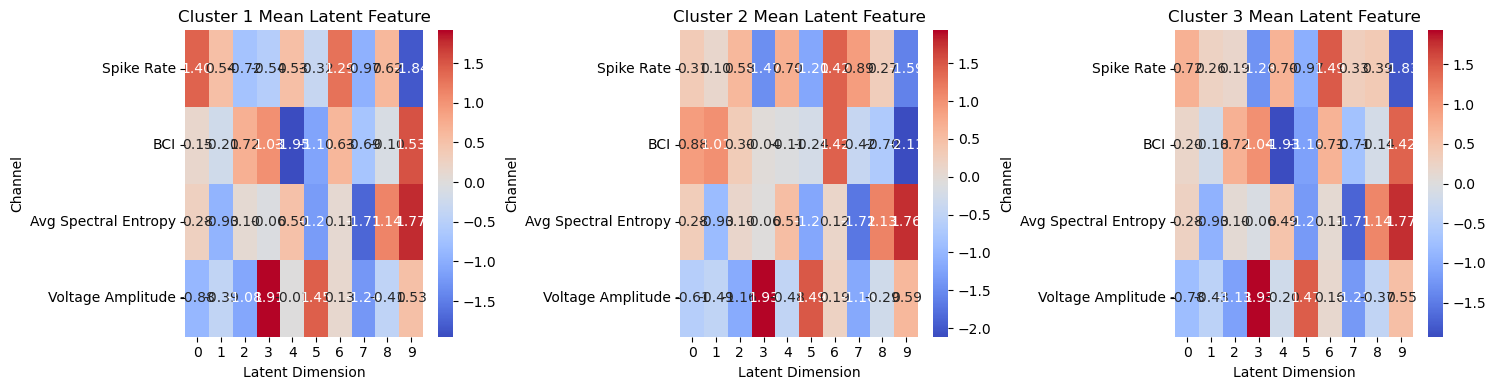

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 获取所有唯一的聚类标签
column_names=['Spike Rate', 'BCI', 'Avg Spectral Entropy', 'Voltage Amplitude']
unique_clusters = np.unique(cluster_labels)
num_clusters = len(unique_clusters)

# 创建图形，每个子图展示一个簇的平均 latent feature（以热力图形式）
fig, axes = plt.subplots(1, num_clusters, figsize=(5 * num_clusters, 4), squeeze=False)
axes = axes.ravel()

for i, cluster in enumerate(unique_clusters):
    # 找到当前簇中的样本索引
    cluster_indices = np.where(cluster_labels == cluster)[0]
    # 计算当前簇中所有样本的平均 latent feature
    cluster_avg = latent_features[cluster_indices].mean(axis=0)  # shape: (num_channels * latent_dim,)
    # 将平均值重新 reshape 为 (num_channels, latent_dim)
    cluster_avg_reshaped = cluster_avg.reshape(num_channels, latent_dim)
    
    ax = axes[i]
    sns.heatmap(cluster_avg_reshaped, ax=ax, cmap='coolwarm', annot=True, fmt=".2f")
    ax.set_title(f"Cluster {cluster+1} Mean Latent Feature")
    ax.set_xlabel("Latent Dimension")
    ax.set_ylabel("Channel")
    # 设置 y 轴刻度标签为 EEG 通道名称
    ax.set_yticklabels(column_names, rotation=0)

plt.tight_layout()
plt.show()